In [1]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl

import pandas as pd
import seaborn as sns

from matplotlib.colors import LinearSegmentedColormap

colors = ['orange', 'teal', 'purple',"cyan","red"] 
plt.rcParams.update({
    #"text.usetex": True,
    #"font.family": "Helvetica", 
    "font.size":14})

import scipy as sp

#tools that may be useful to analyse the data

#function to draw the posterior distribution
def pairplot_from_array(parameter, column_names=None, hue=None, save_path=None,bins=20):
    if not isinstance(parameter, np.ndarray):
        raise ValueError("parameter is not a numpy array")

    if column_names is None:
        column_names = [f"Columns_{i}" for i in range(parameter.shape[1])]

    df = pd.DataFrame(parameter, columns=column_names)

    if hue is not None and hue not in column_names:
        raise ValueError(f"The columns '{hue}' ")
    
    plot_kws = {"bins": bins}

    
    if len(parameter)<=10000:
        sns.pairplot(df, hue=hue, corner=True, kind="kde", plot_kws=plot_kws)
    else:
        sns.pairplot(df, hue=hue, corner=True, kind="hist",diag_kind="kde", plot_kws=plot_kws)
        
    plt.show()
    
def plot_convergence(parameter, column_names=None):
    if not isinstance(parameter, np.ndarray):
        raise ValueError("parameter is not a numpy array")

    if column_names is None:
        column_names = [f"Columns_{i}" for i in range(parameter.shape[1])]
    for i in range(parameter.shape[1]):
        fig, ax = plt.subplots(1,1,figsize=(8, 5))
        ax.plot(parameter[:,i])
        ax.set_xlabel("step")
        ax.set_ylabel(column_names[i])
        ax.set_xscale("log")
    plt.show()

    
def plot_convergence_method(parameter, column_names=None, method_names=None):
    if not isinstance(parameter, np.ndarray):
        raise ValueError("parameter is not a numpy array")

    if column_names is None:
        column_names = [f"Columns_{i}" for i in range(parameter.shape[2])]
    if method_names is None:
        method_names = [f"method_{i}" for i in range(parameter.shape[0])]
    for i in range(parameter.shape[2]):
        fig, ax = plt.subplots(1,1,figsize=(8, 5))
        for j in range(parameter.shape[0]):
            ax.plot(parameter[j,:,i],label=method_names[j],alpha=0.5,color=colors[j+1])
        ax.set_xlabel("step")
        ax.legend()
        ax.set_ylabel(column_names[i])
        ax.set_xscale("log")
    plt.show()

def autocorrelation(data):
    n = len(data)
    
    mean = np.mean(data)
    centered_data = data - mean
    
    variance = np.dot(centered_data, centered_data)
    
    result = np.correlate(centered_data, centered_data, mode='full') / variance
    result = result[n-1:]
    return result    

def plot_autocorrelation(parameter, column_names=None):
    if not isinstance(parameter, np.ndarray):
        raise ValueError("parameter is not a numpy array")

    if column_names is None:
        column_names = [f"Columns_{i}" for i in range(parameter.shape[1])]
    for i in range(parameter.shape[1]):
        fig, ax = plt.subplots(1,1,figsize=(8, 5))
        ax.plot(autocorrelation(parameter[:,i]))
        ax.set_xlabel("lag")
        ax.set_ylabel("autocorrelation("+column_names[i]+")")
        ax.set_xscale("log")
    plt.show()

    
def plot_autocorrelation_method(parameter, column_names=None, method_names=None):
    if not isinstance(parameter, np.ndarray):
        raise ValueError("parameter is not a numpy array")

    if column_names is None:
        column_names = [f"Columns_{i}" for i in range(parameter.shape[2])]
    if method_names is None:
        method_names = [f"method_{i}" for i in range(parameter.shape[0])]
    for i in range(parameter.shape[2]):
        fig, ax = plt.subplots(1,1,figsize=(8, 5))
        for j in range(parameter.shape[0]):
            ax.plot(autocorrelation(parameter[j,:,i]),
                    label=method_names[j],alpha=0.5,color=colors[j+1])
        ax.set_xlabel("lag")
        ax.legend()
        ax.set_ylabel("autocorrelation("+column_names[i]+")")
        ax.set_xscale("log")
    plt.show()

def plot_hist(hist,xbin, title = None):
    fig, ax = plt.subplots(1,1,figsize=(8, 5))
    ax.hist((xbin[:-1]+xbin[1:])/2.,bins=xbin,weights=hist)
    ax.set_xlabel("x_bin")
    if title != None:
        ax.set_title(title)
    plt.show()
    
def plot_acceptance_rate(parameters, title = None, number_of_batch = 10):
    n = len(parameters)
    batch_size = int(n/number_of_batch)
    print(batch_size)
    acceptation = []
    for i in range(number_of_batch):
        unique_values, occurrences = np.unique(parameters[i*batch_size:(i+1)*batch_size,:], 
                                               axis=0, return_counts=True)
        acceptation.append(float(len(unique_values))/float(batch_size))
    fig, ax = plt.subplots(1,1,figsize=(8, 5))
    ax.plot(acceptation,color=colors[2])
    ax.set_xlabel("batch")
    ax.set_ylabel("acceptance ratio")
    if title != None:
        ax.set_title(title)
    plt.show()
    
###############################################################################
# function to compute the likelihood between a model and histogrammed data.

# compute poisson likelihood between a model array and histogrammed data
def compute_poisson_loglikelihood(model, histo_data):
    logf = np.log(sp.special.factorial(histo_data))
    logf[np.isinf(logf)==True] = ((histo_data[np.isinf(logf)==True])*
                                  np.log(histo_data[np.isinf(logf)==True])-
                                  histo_data[np.isinf(logf)==True]+1.)
    LL = np.sum(-model+histo_data*np.log(model)-logf)
    return LL
    
# compute normal likelihood between a model array and histogrammed data
def compute_normal_loglikelihood(model, histo_data, sigma):
    LL = np.sum(-(model-histo_data)**2/(2.*sigma**2))
    return LL

###################################################
#exponential decay model

#sample generator according to exponential decay (exp(-lambda*t))
#input: 
#  - n : number of sample
#  - lambda : decay rate
def run_sample_exp_decay(n,lamb):
    return np.random.exponential(1./lamb, size=n)

#compute the expted value in each bin for a exponantial decay of n event :
#input:
#  - n : number of sample
#  - lambda : decay rate
#  - xbin : the bin edge of the histogram
def compute_expectation_exp_decay(n,lamb,xbin):
    model = -n*(np.exp(-lamb*xbin[1:])-
                np.exp(-lamb*xbin[:-1]))
    return model

###################################################
#background model

#sample generator according to uniform background
#input: 
#  - rate : rate in time unit
#  - tmin, tmax : interval for the event generation
def run_sample_uniform_bck(rate, tmin, tmax):
    dt = tmax-tmin
    nevt = np.random.poisson(rate*dt,1)
    return np.random.uniform(tmin,tmax,nevt)
    
#compute the expected value for uniform background
#input: 
#  - rate : rate in unit
#  - xbin : the bin edge of the histogram
def compute_expectation_uniform_bck(rate,xbin):
    model = np.zeros_like(xbin[:-1])+rate*(xbin[1]-xbin[0])
    return model

###################################################
#Normal model

#sample generator according to normal distribution
#input: 
#  - A : number of event
#  - mu, 
#  - sigma
def run_sample_normal(A, mu, sigma):
    return np.random.normal(mu,sigma,A)
    
#compute the expected value for normal distribution
#input: 
#  - A, mu, sigma : rate in time unit
#  - xbin : the bin edge of the histogram
def compute_expectation_normal(A,mu,sigma,xbin):
    model = sp.stats.norm.cdf(xbin[1:], loc=mu, scale=sigma) - sp.stats.norm.cdf(xbin[:-1], loc=mu, scale=sigma)
    return model*A

In [2]:
#my helper functions

def plot_histogram_components(data,n_bins=None,var_names=None,var_names_files=None,f_list=None,filename=None):
    if var_names == None:
        var_names = ["$z_e$","$z_\\nu$","$\\phi$ (rad)"]
    if var_names_files == None:
        var_names_files = ["_ze","_znu","_phi"]
    data_count = data.shape[0]
    if (n_bins == None):
        n_bins = int(np.sqrt(data_count))
    try:
        n_params = data.shape[1]
    except:
        n_params = 1
        data = np.stack([data,np.zeros_like(data)],axis=-1)
        
    for i in range(n_params):
        fig, ax = plt.subplots(figsize=(6,6))
        ax.set_xlabel(var_names[i])
        ax.set_ylabel("Counts")
        ax.hist(data[:,i],bins=n_bins)
        if f_list != None:
            if i == 2:
                x = np.linspace(0,2*np.pi,10000)
            else:
                x = np.linspace(-1,1,10000)
            plt.plot(x,f_list[i](x)*data_count/n_bins,linewidth=3)
        fig.tight_layout()
        if filename != None:
            fig.savefig(filename+var_names_files[i]+".png")
        plt.show()
        
def plot_pairplot(data,n_bins=None,filename=None,f_list=None):
    data_count = data.shape[0]
    if (n_bins == None):
        n_bins = int(np.sqrt(data_count))
    dim = data.shape[1]
    var_names = ["$z_e$","$z_\\nu$","$\\phi$ (rad)"]
    var_names_files = ["_ze","_znu","_phi"]
    fig, Axes = plt.subplots(dim,dim,figsize=(5*dim,5*dim))
    for i in range(dim):
        for j in range(dim):
            ax = Axes[i,j]
            if i == j:
                ax.set_xlabel(var_names[i],size=20)
                ax.set_ylabel("Bin Count",size=20)
                ax.hist(data[:,i],bins=n_bins)
                if f_list != None:
                    if i == 2:
                        x = np.linspace(0,2*np.pi,10000)
                    else:
                        x = np.linspace(-1,1,10000)
                    f_theory = f_list[i](x)*data_count/n_bins
                    print(f_theory.sum())
                    ax.plot(x,f_theory,linewidth=3)
            else:
                ax.set_xlabel(var_names[j],size=20)
                ax.set_ylabel(var_names[i],size=20)
                ax.hist2d(data[:,j],data[:,i],bins=30,vmin = 0)
    fig.tight_layout()
    if filename != None:
        fig.savefig(filename+"pairplot.png")
    plt.show()
    plt.show()

a


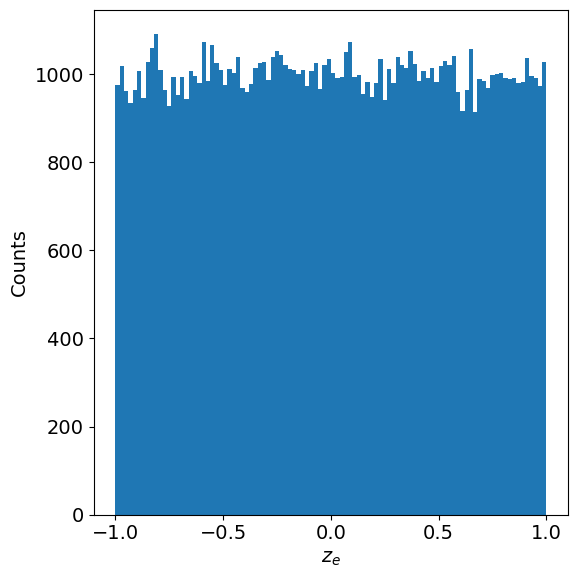

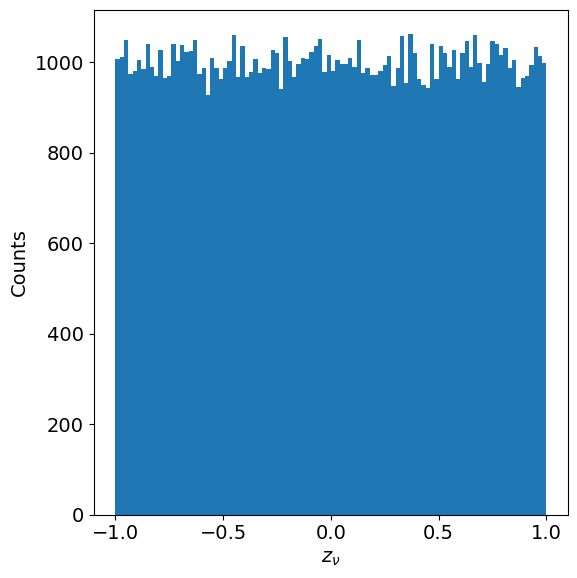

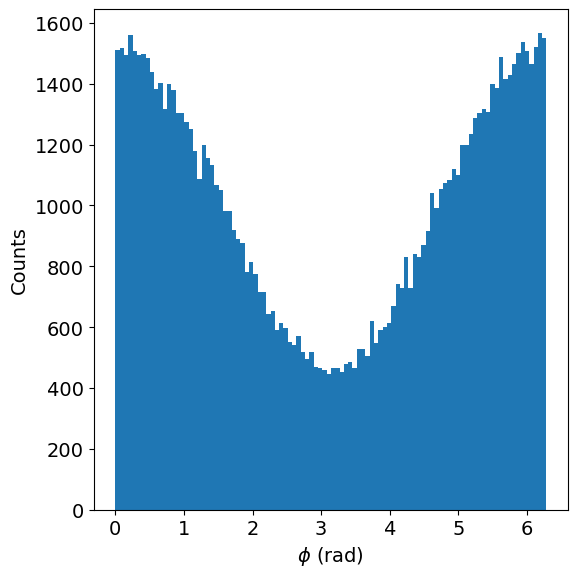

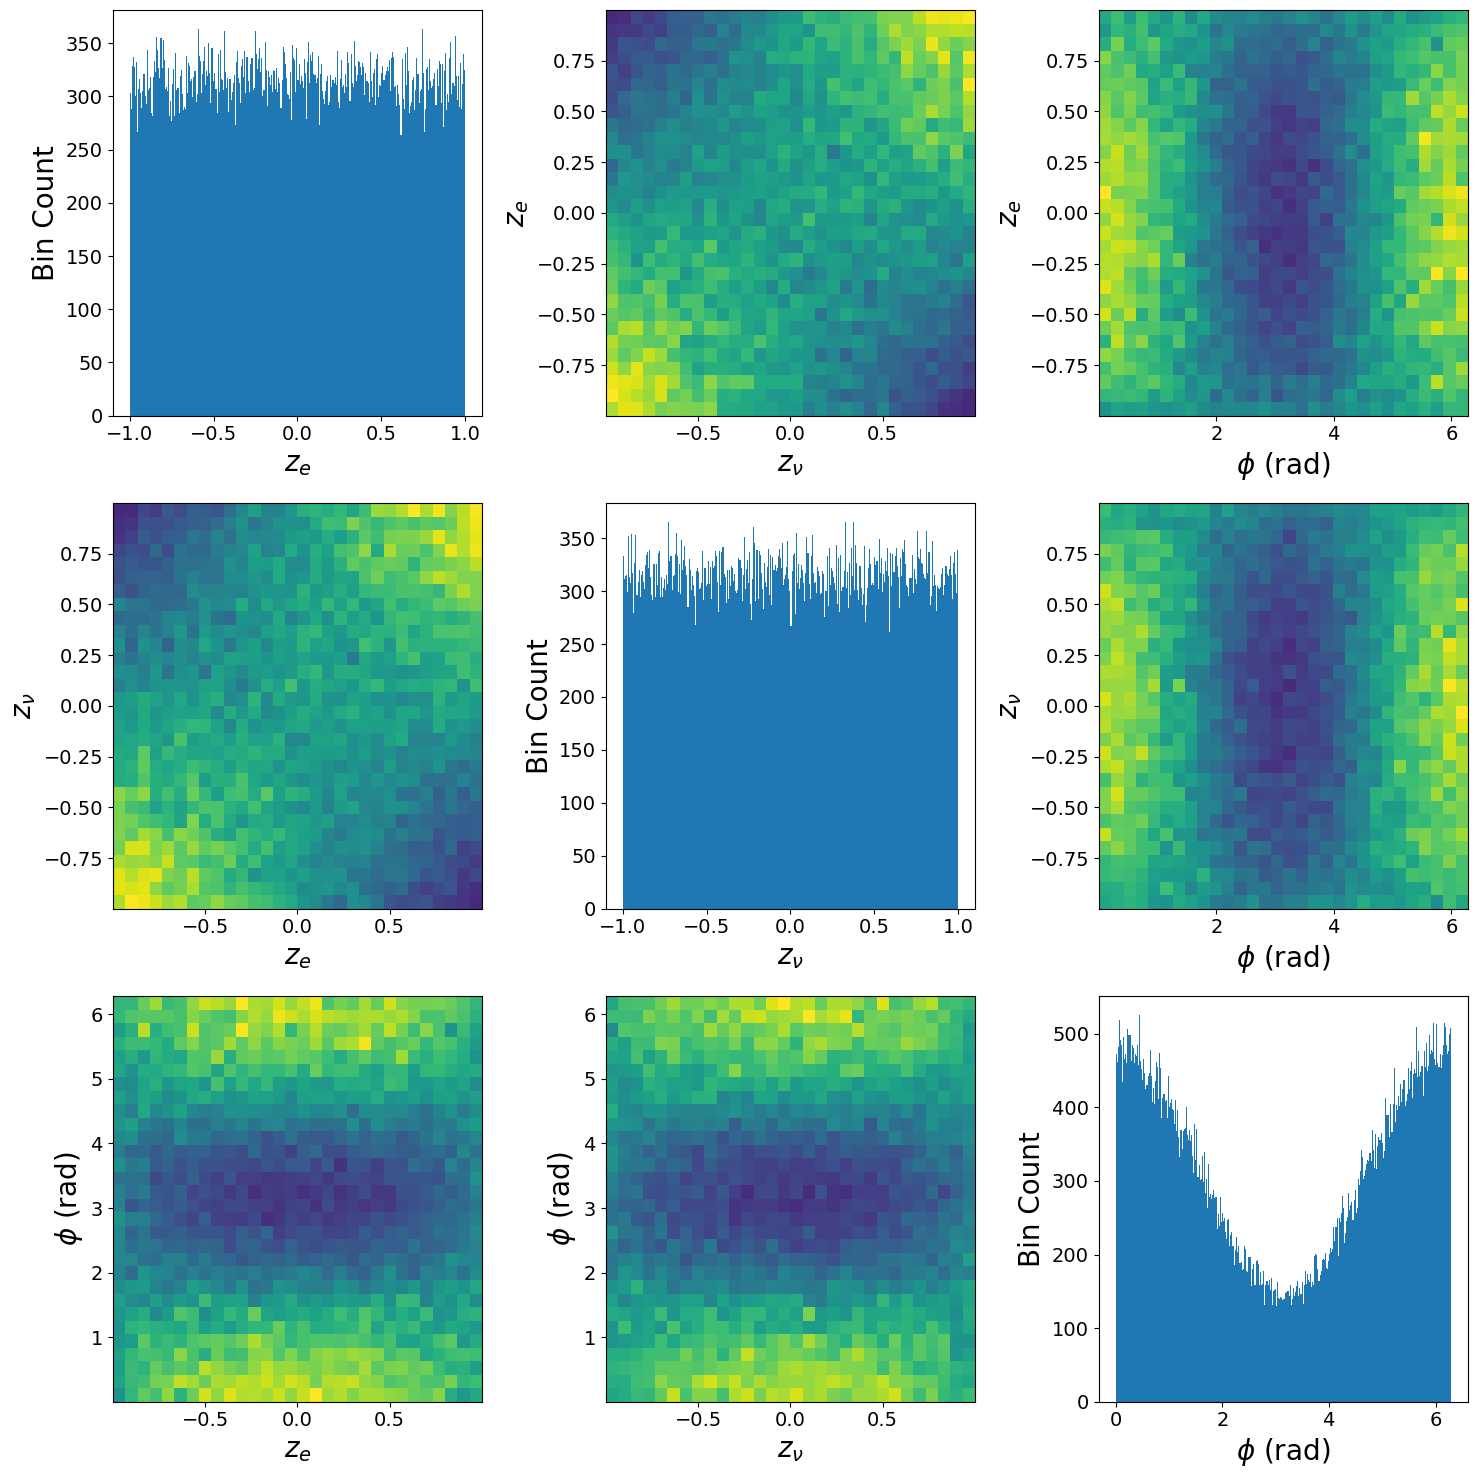

A


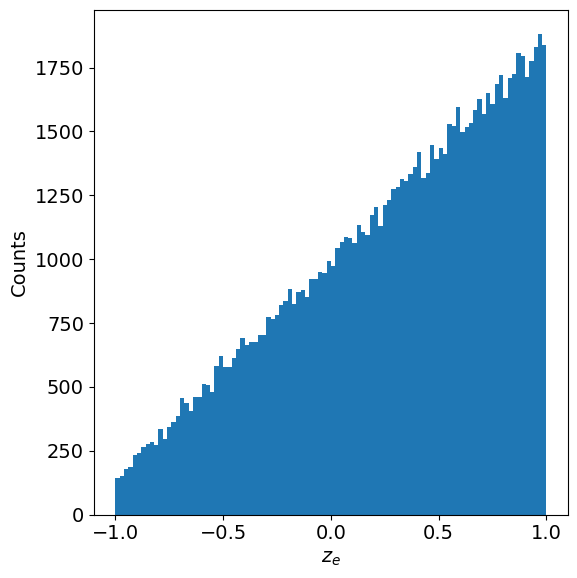

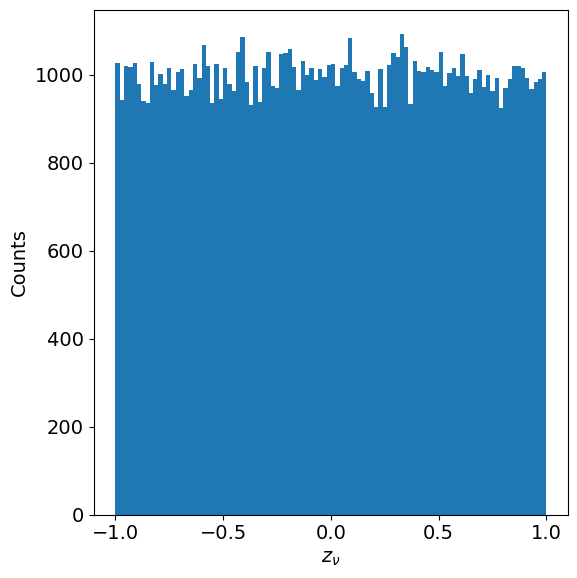

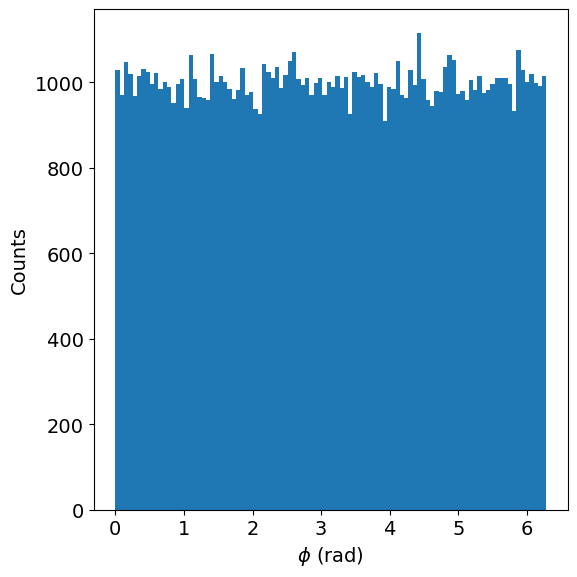

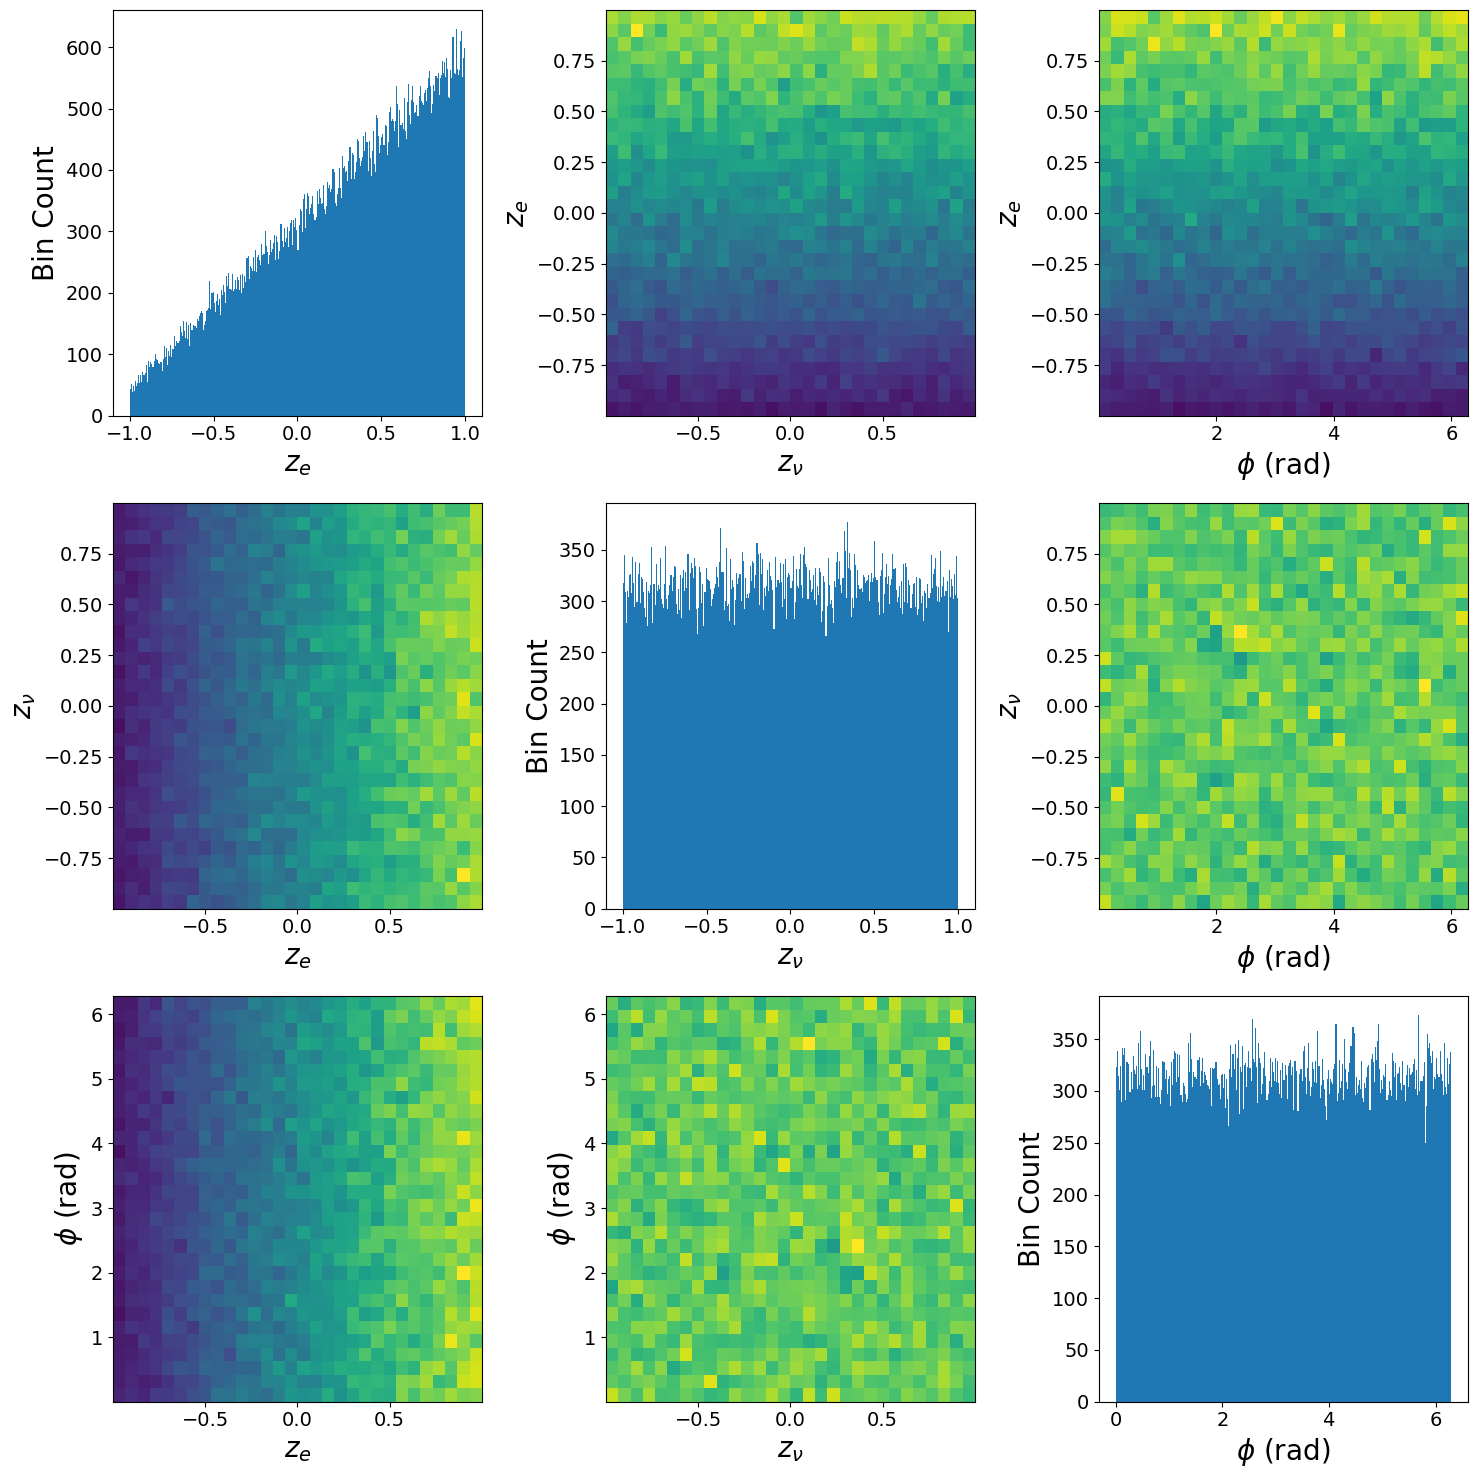

B


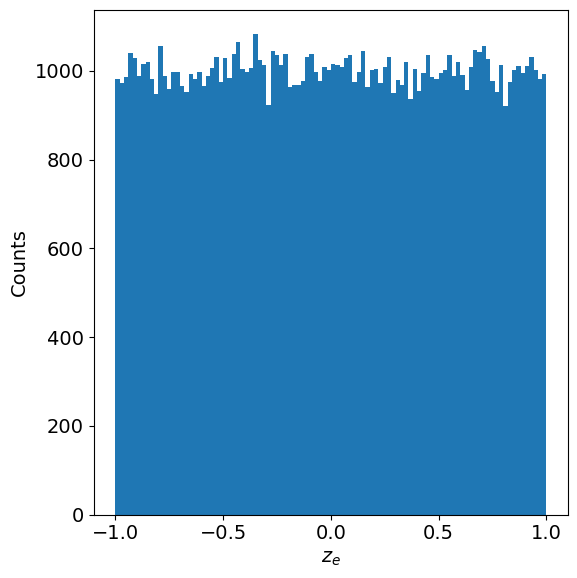

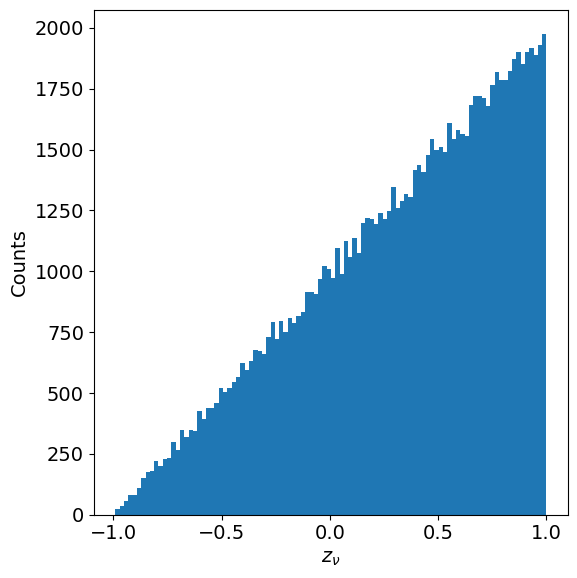

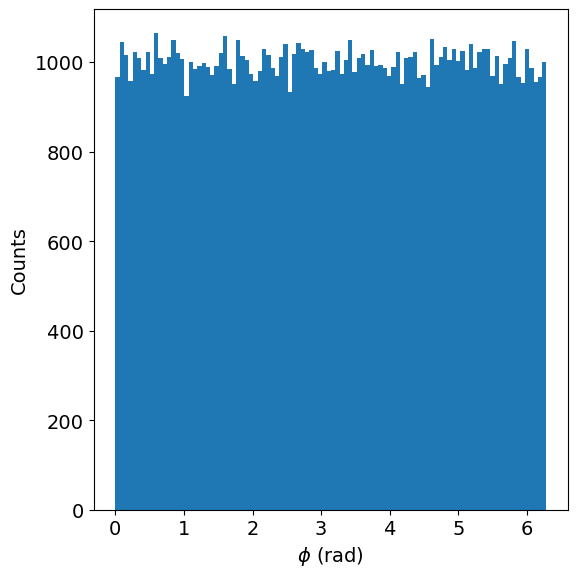

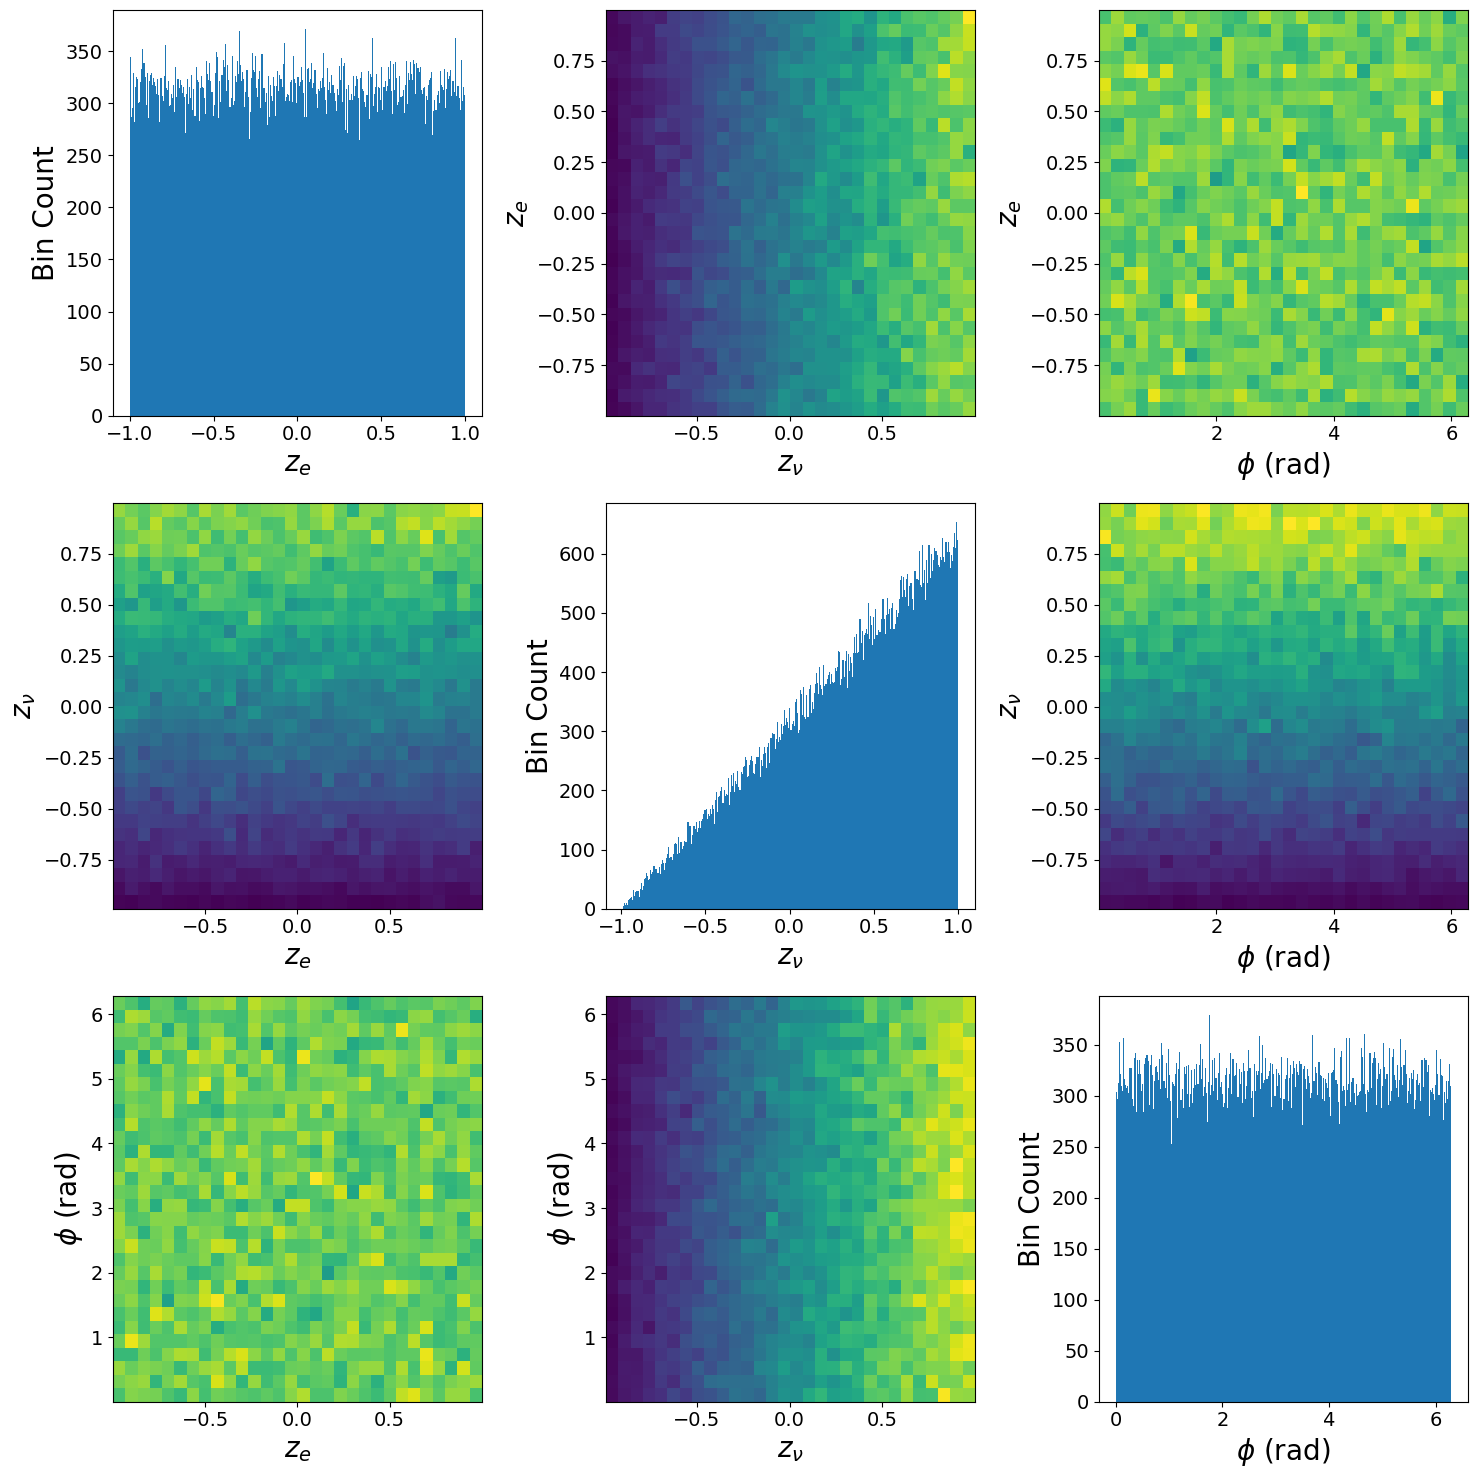

D


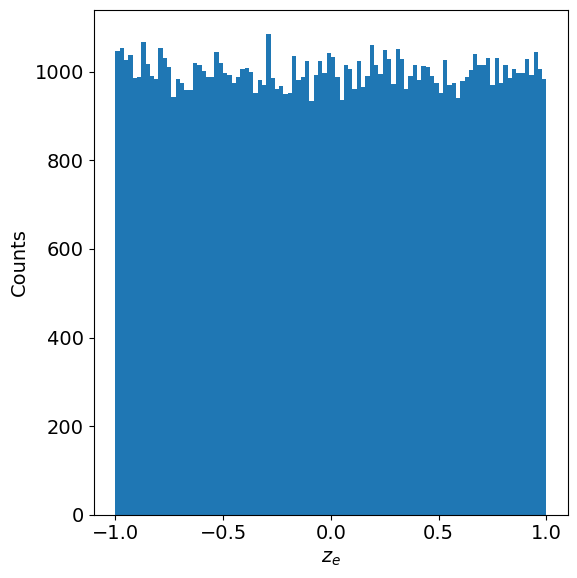

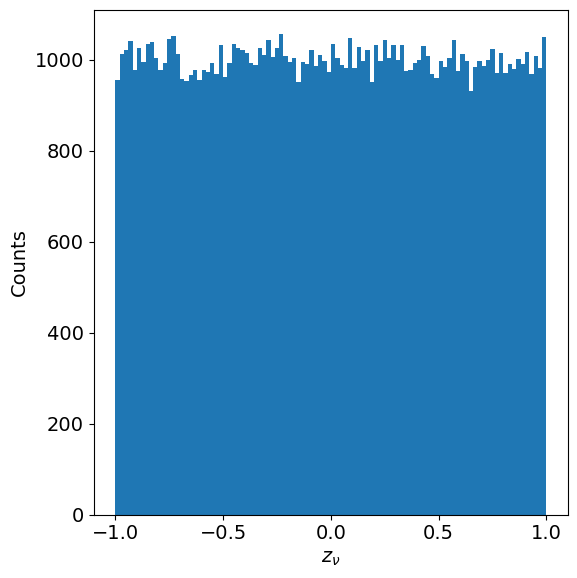

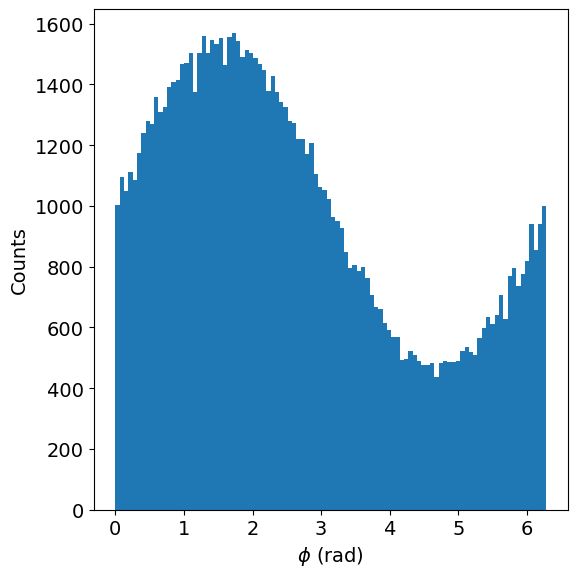

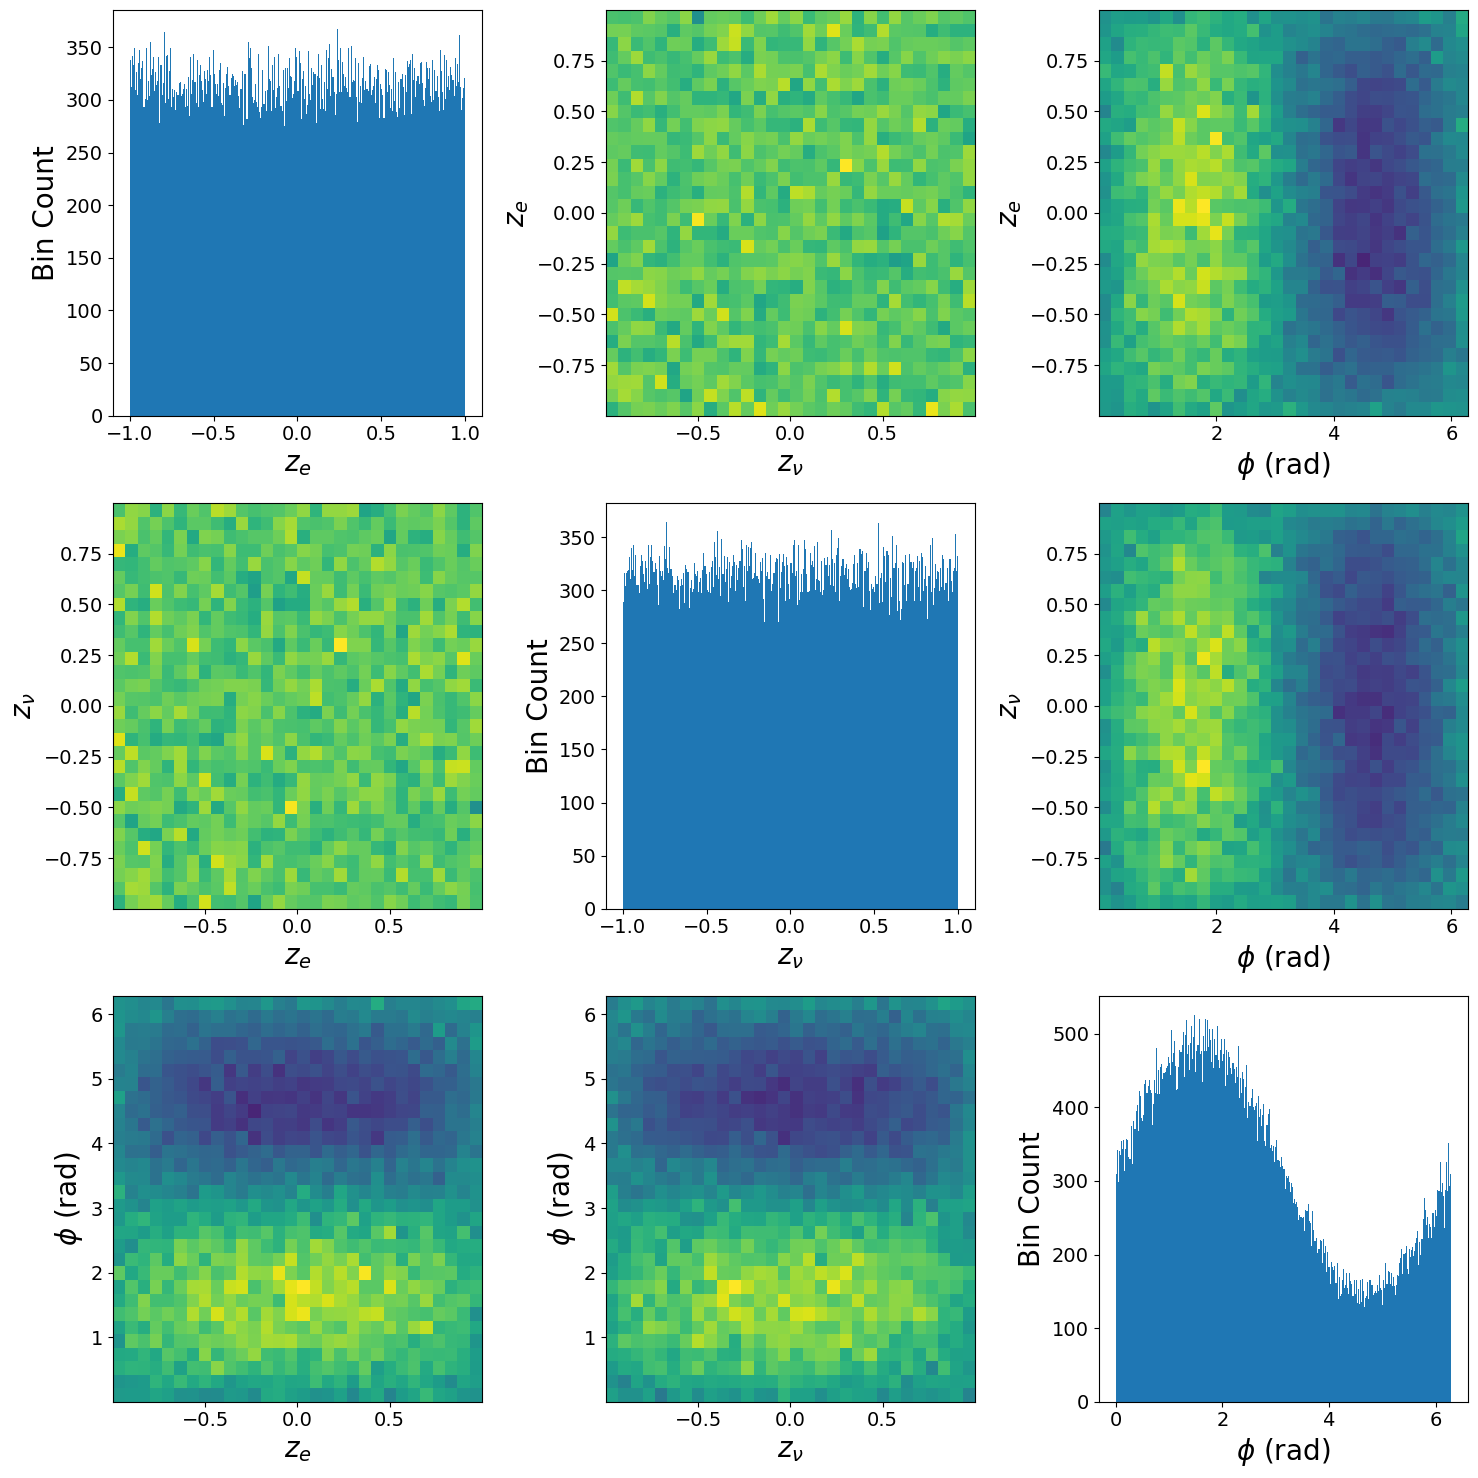

In [3]:
coeffNames = ["a","A","B","D"]

for name in coeffNames:
    print(name)
    filename = f"build/sample_{name}.txt"
    data = np.loadtxt(filename)
    plot_histogram_components(data,100)
    plot_pairplot(data,filename=f"plots/sample_{name}")

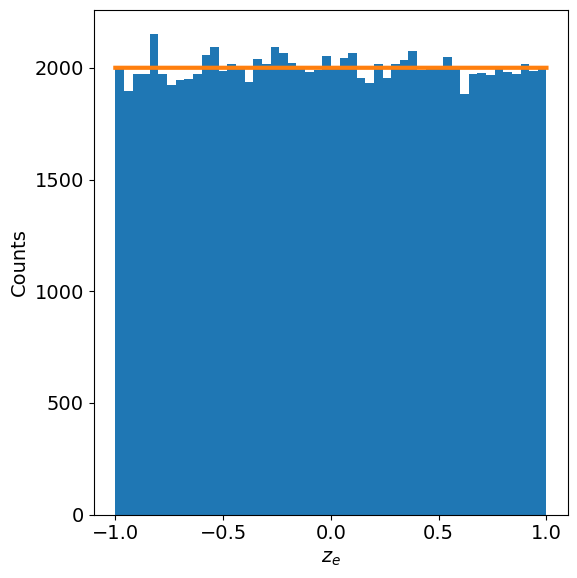

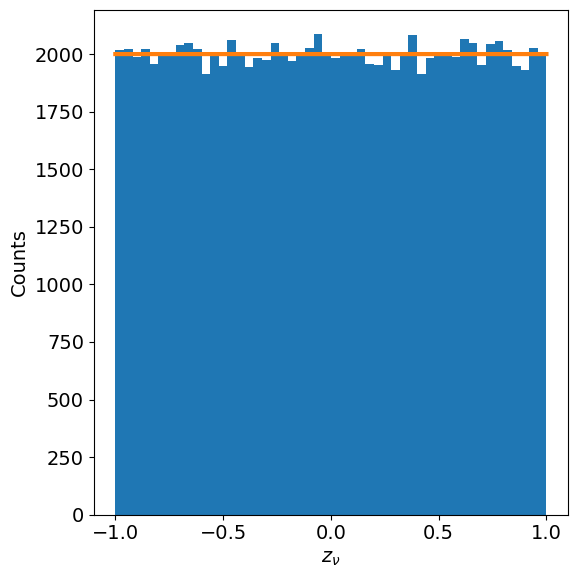

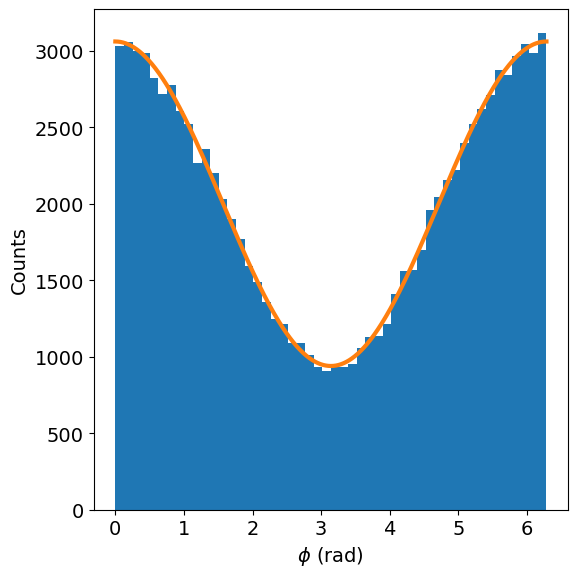

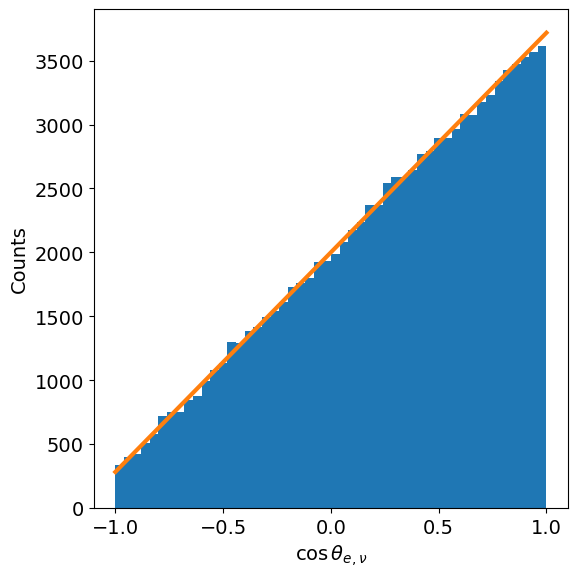

In [4]:
data = np.loadtxt("build/sample_a.txt")
beta = np.sqrt(1-511**2/1000**2)

def fx(x):
    return np.ones_like(x)

def fz(x):
    return 1+beta*np.cos(x)*(np.pi/4)**2

def fcos(x):
    return 1+beta*x

ze, znu, phi = [data[:,i] for i in range(3)]

data_cos = ze*znu+np.sqrt(1-ze**2)*np.sqrt(1-znu**2)*np.cos(phi)

    
plot_histogram_components(data,n_bins=50,f_list=[fx,fx,fz],filename="plots/hist_a")
plot_histogram_components(data_cos,n_bins=50,var_names=["$\\cos \\theta_{e,\\nu}$"],
                          var_names_files=["_cos_enu"],f_list=[fcos],filename="plots/hist_a")

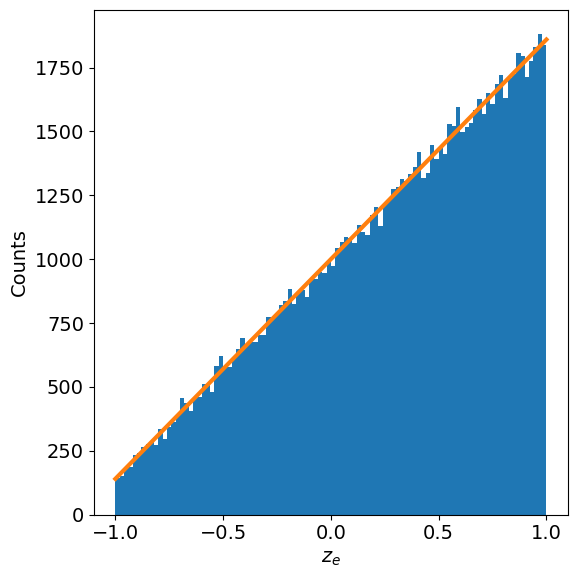

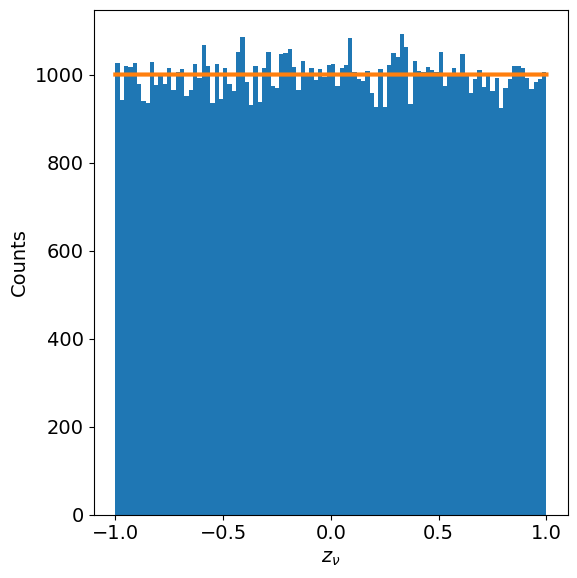

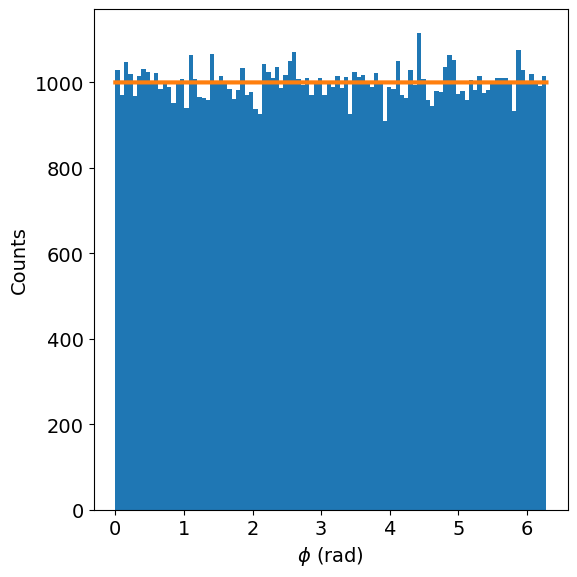

In [5]:
data = np.loadtxt("build/sample_A.txt")
beta = np.sqrt(1-511**2/1000**2)

def fx(x):
    return 1+beta*x

def fy(x):
    return np.ones_like(x)
    
plot_histogram_components(data,100,f_list=[fx,fy,fy],filename="plots/hist_A")

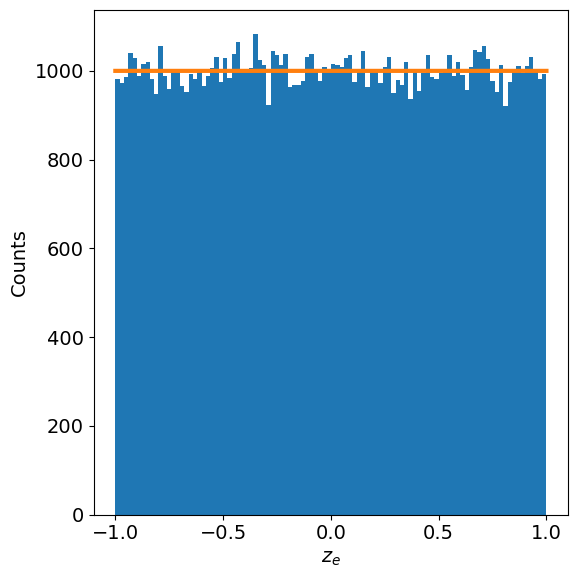

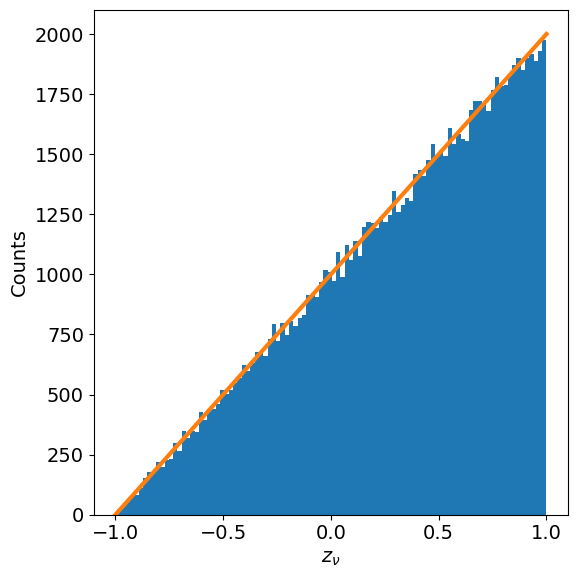

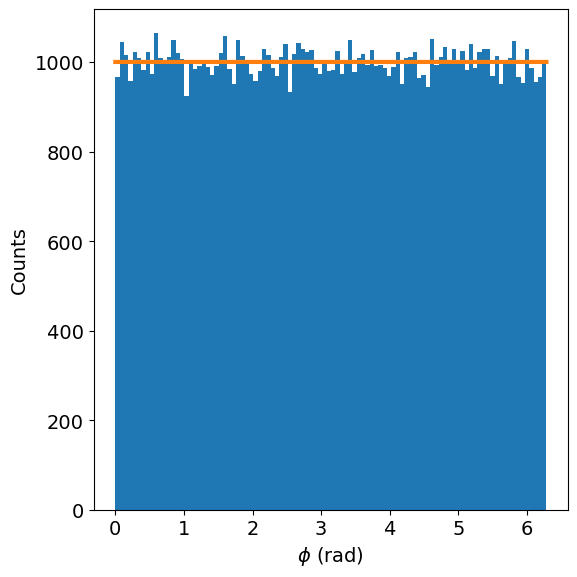

In [6]:
data = np.loadtxt("build/sample_B.txt")
beta = np.sqrt(1-511**2/1000**2)

def fx(x):
    return np.ones_like(x)

def fy(x):
    return 1+x
    
plot_histogram_components(data,100,f_list=[fx,fy,fx],filename="plots/hist_B")

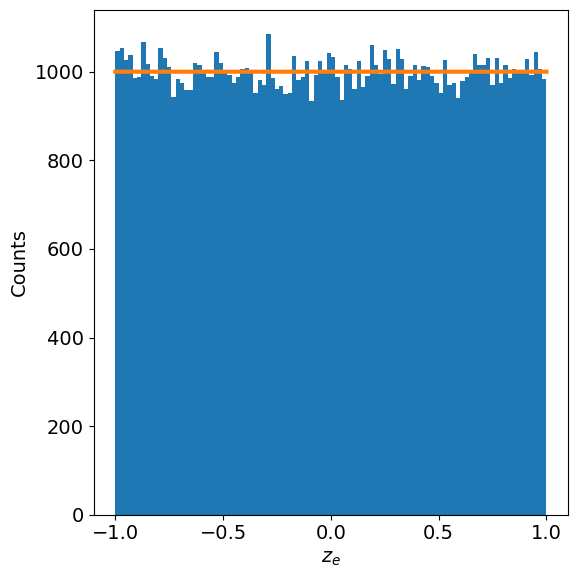

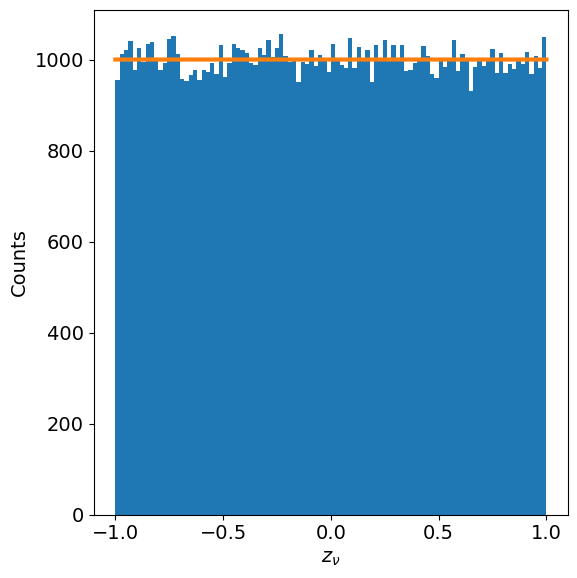

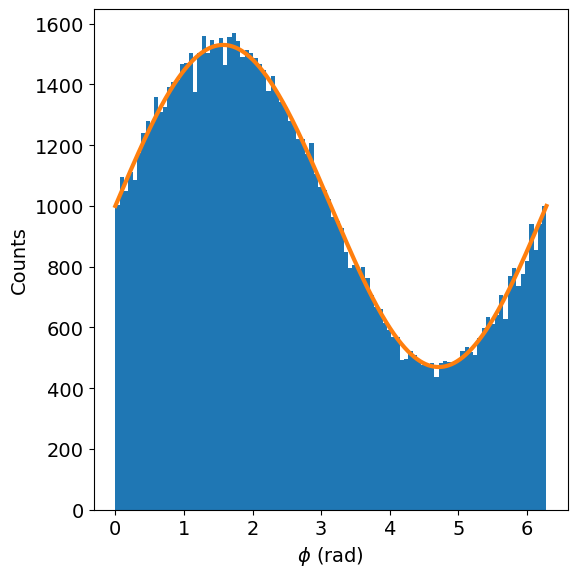

In [7]:
data = np.loadtxt("build/sample_D.txt")
beta = np.sqrt(1-511**2/1000**2)

def fx(x):
    return np.ones_like(x)

def fz(x):
    return 1+beta*np.sin(x)*(np.pi/4)**2
    
plot_histogram_components(data,100,f_list=[fx,fx,fz],filename="plots/hist_D")

build/sample_posA_posB_lowE.txt
build/posA_posB_lowE.txt


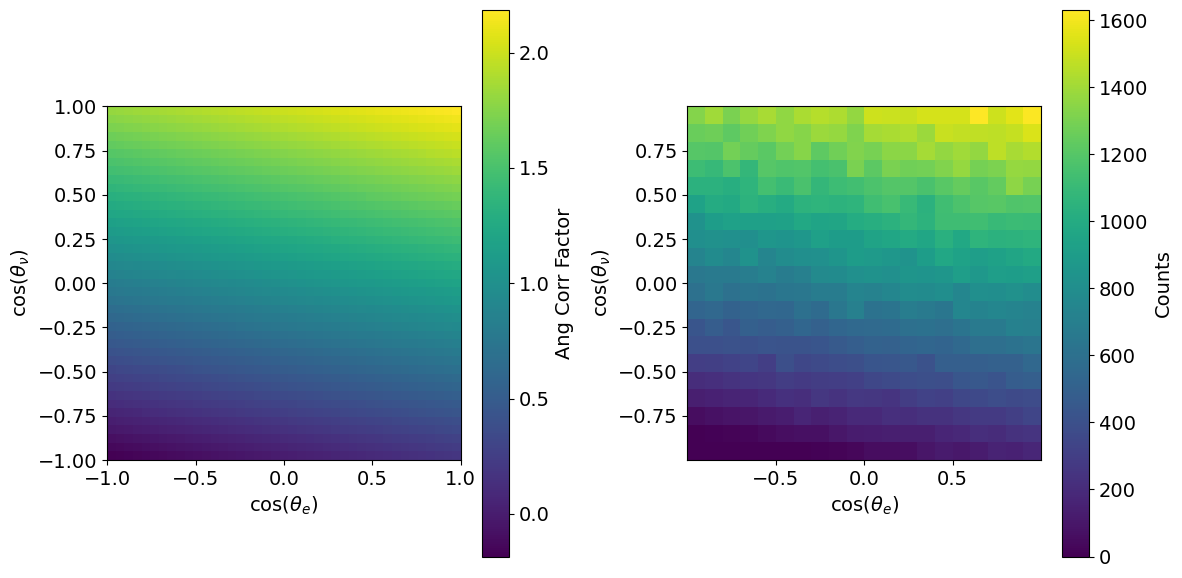

build/sample_posA_posB_medE.txt
build/posA_posB_medE.txt


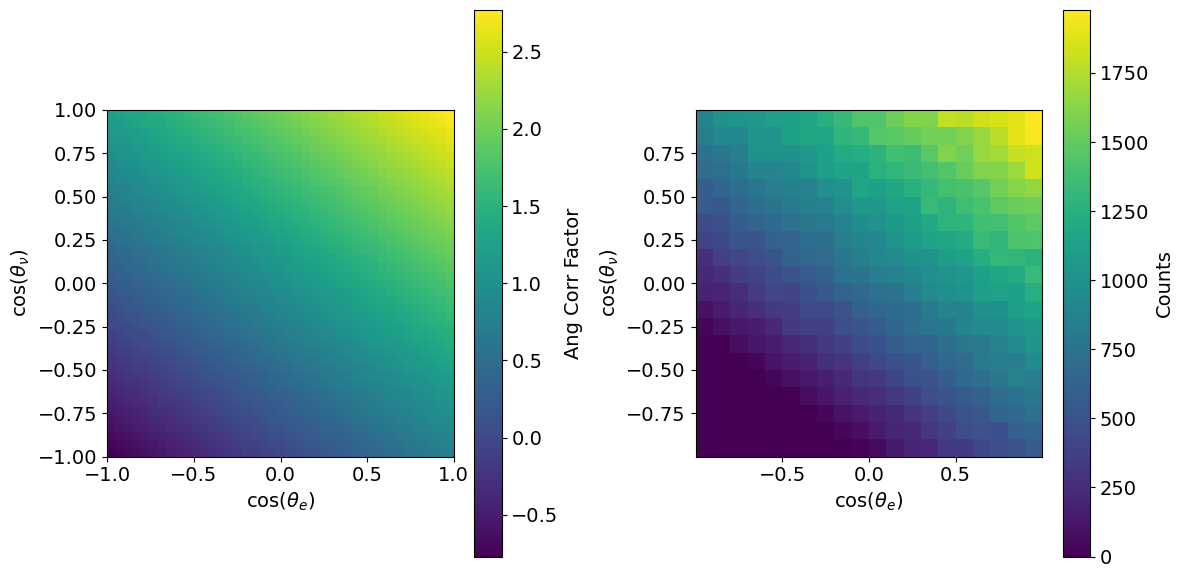

build/sample_posA_posB_hiE.txt
build/posA_posB_hiE.txt


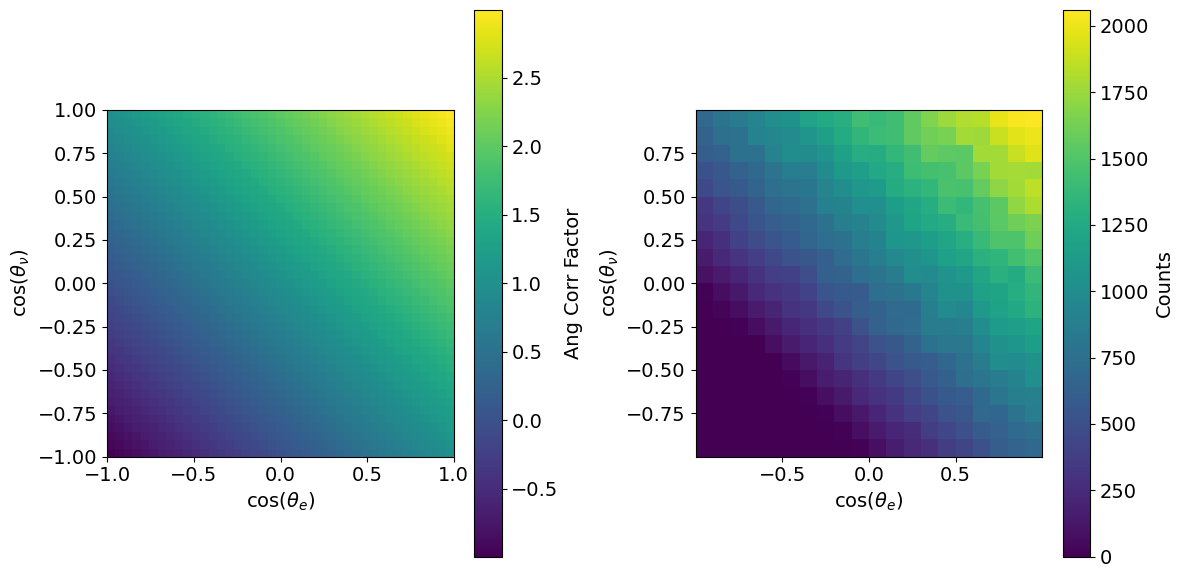

build/sample_posA_posB_hiA.txt
build/posA_posB_hiA.txt


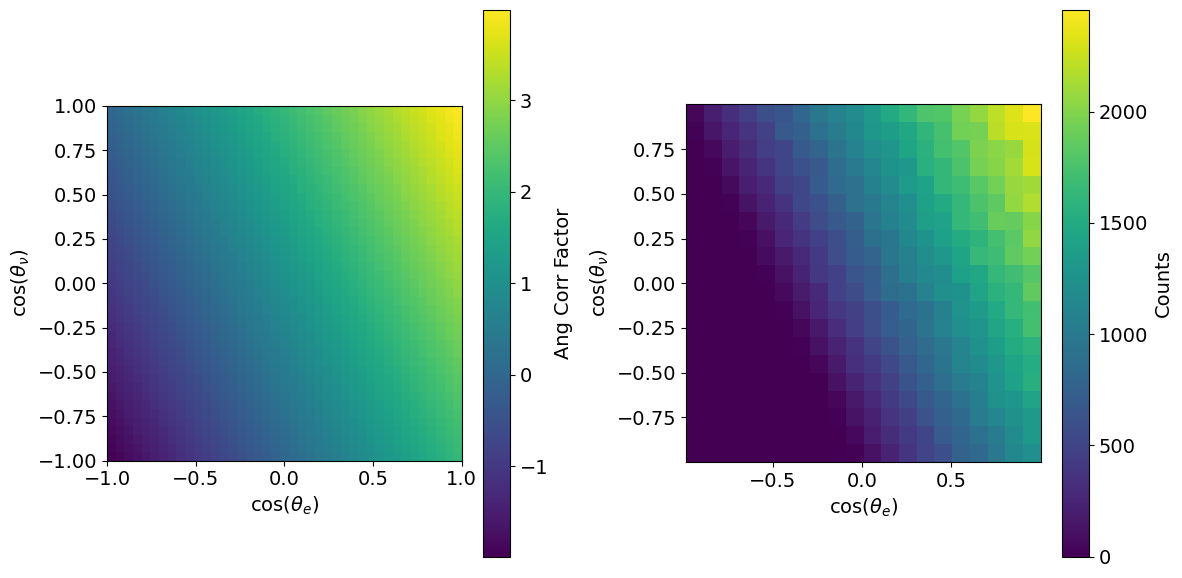

build/sample_posA_posB_vhiA.txt
build/posA_posB_vhiA.txt


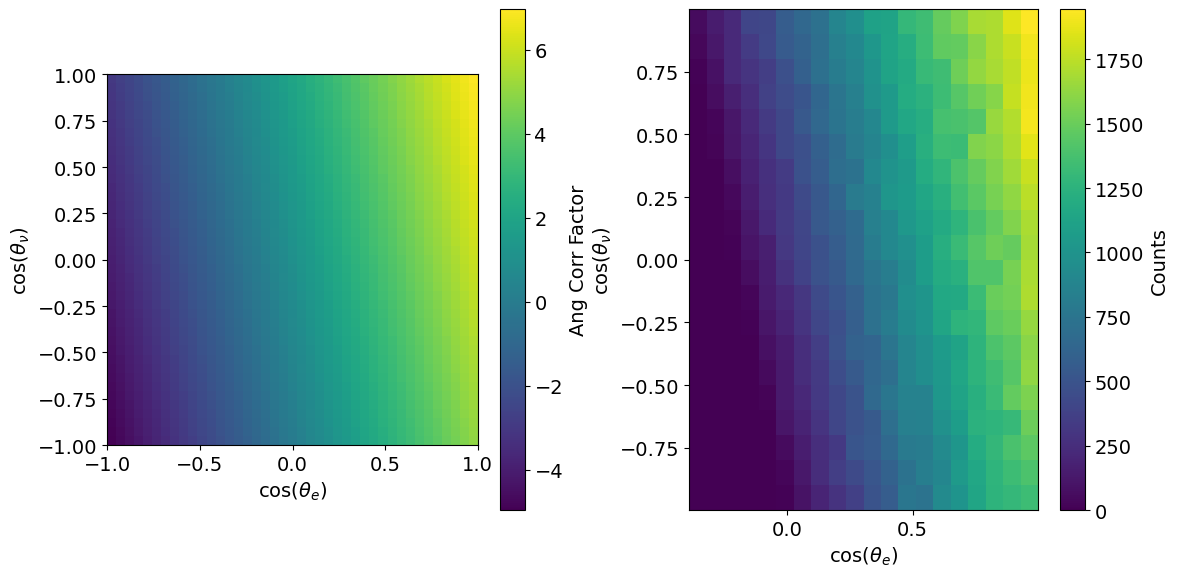

build/sample_posA_negB_lowE.txt
build/posA_negB_lowE.txt


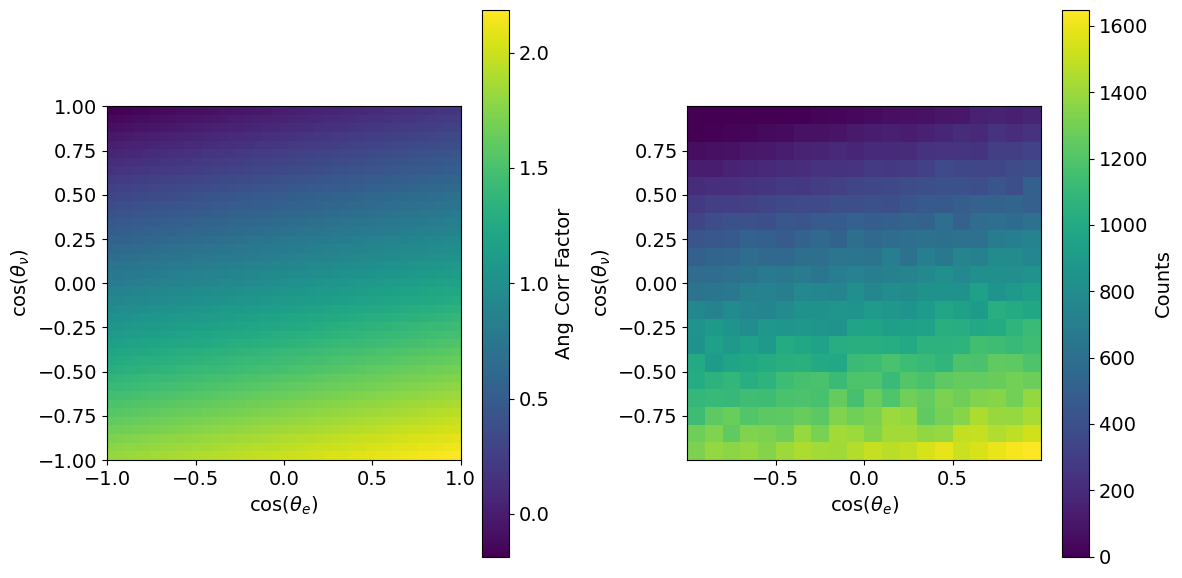

build/sample_posA_negB_hiE.txt
build/posA_negB_hiE.txt


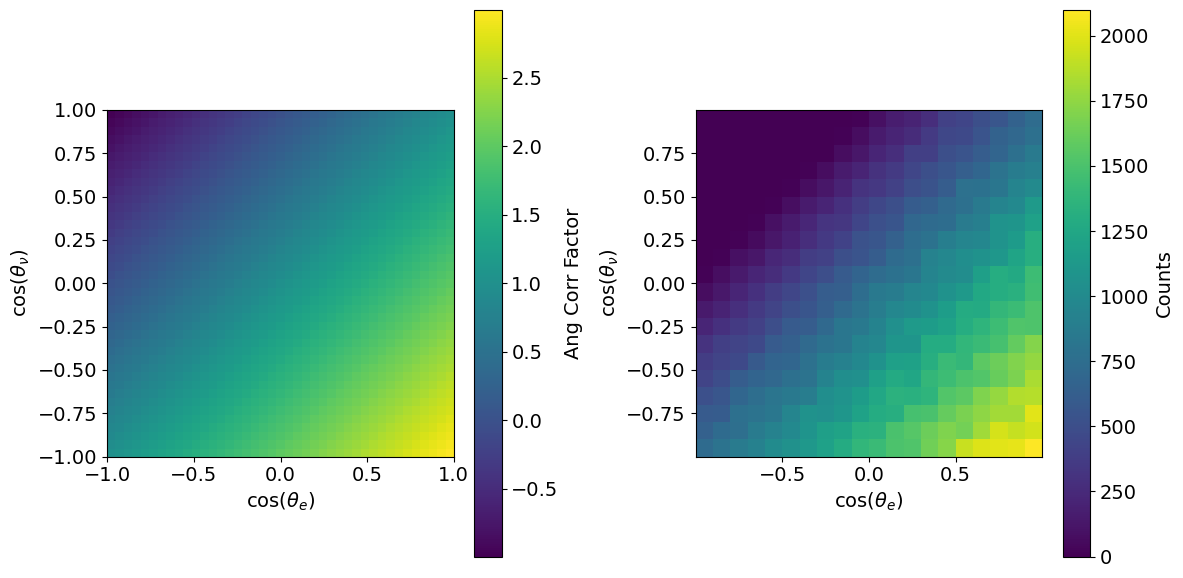

In [8]:
fileNames = ["build/sample_posA_posB_lowE.txt","build/sample_posA_posB_medE.txt","build/sample_posA_posB_hiE.txt",
             "build/sample_posA_posB_hiA.txt","build/sample_posA_posB_vhiA.txt",
             "build/sample_posA_negB_lowE.txt","build/sample_posA_negB_hiE.txt"]


for filename in fileNames:  
    print(filename)
    data = np.loadtxt(filename)
    filename2 = filename[:6]+filename[13:]
    print(filename2)
    data2 = np.loadtxt(filename2)
    #print(data.shape)
    z_vals = int(np.sqrt(data2.shape[0]))
    x_max = z_vals//2 

    data2 = np.array(np.split(data2,z_vals,axis=0))  
    #print(data.shape)

    fig, axs = plt.subplots(1,2,figsize=(6*2,6))
    im2d = axs[0].imshow(data2[:,:,0].T,extent=(-1,1,-1,1),origin="lower")
    axs[0].set_xlabel("$\\cos(\\theta_e)$")
    axs[0].set_ylabel("$\\cos(\\theta_\\nu)$")
    fig.colorbar(im2d,label="Ang Corr Factor",shrink=1,fraction=0.1)
    ax = axs[1]
    histo2d = ax.hist2d(data[:,0],data[:,1],bins=20)
    ax.set_xlabel("$\\cos(\\theta_e)$")
    ax.set_ylabel("$\\cos(\\theta_\\nu)$")
    ax.set_aspect('equal')
    fig.colorbar(histo2d[3],label="Counts",shrink=1,fraction=0.1)
    fig.tight_layout()
    fig.savefig(f"plots/{filename[6:-4]}.png")
    plt.show()

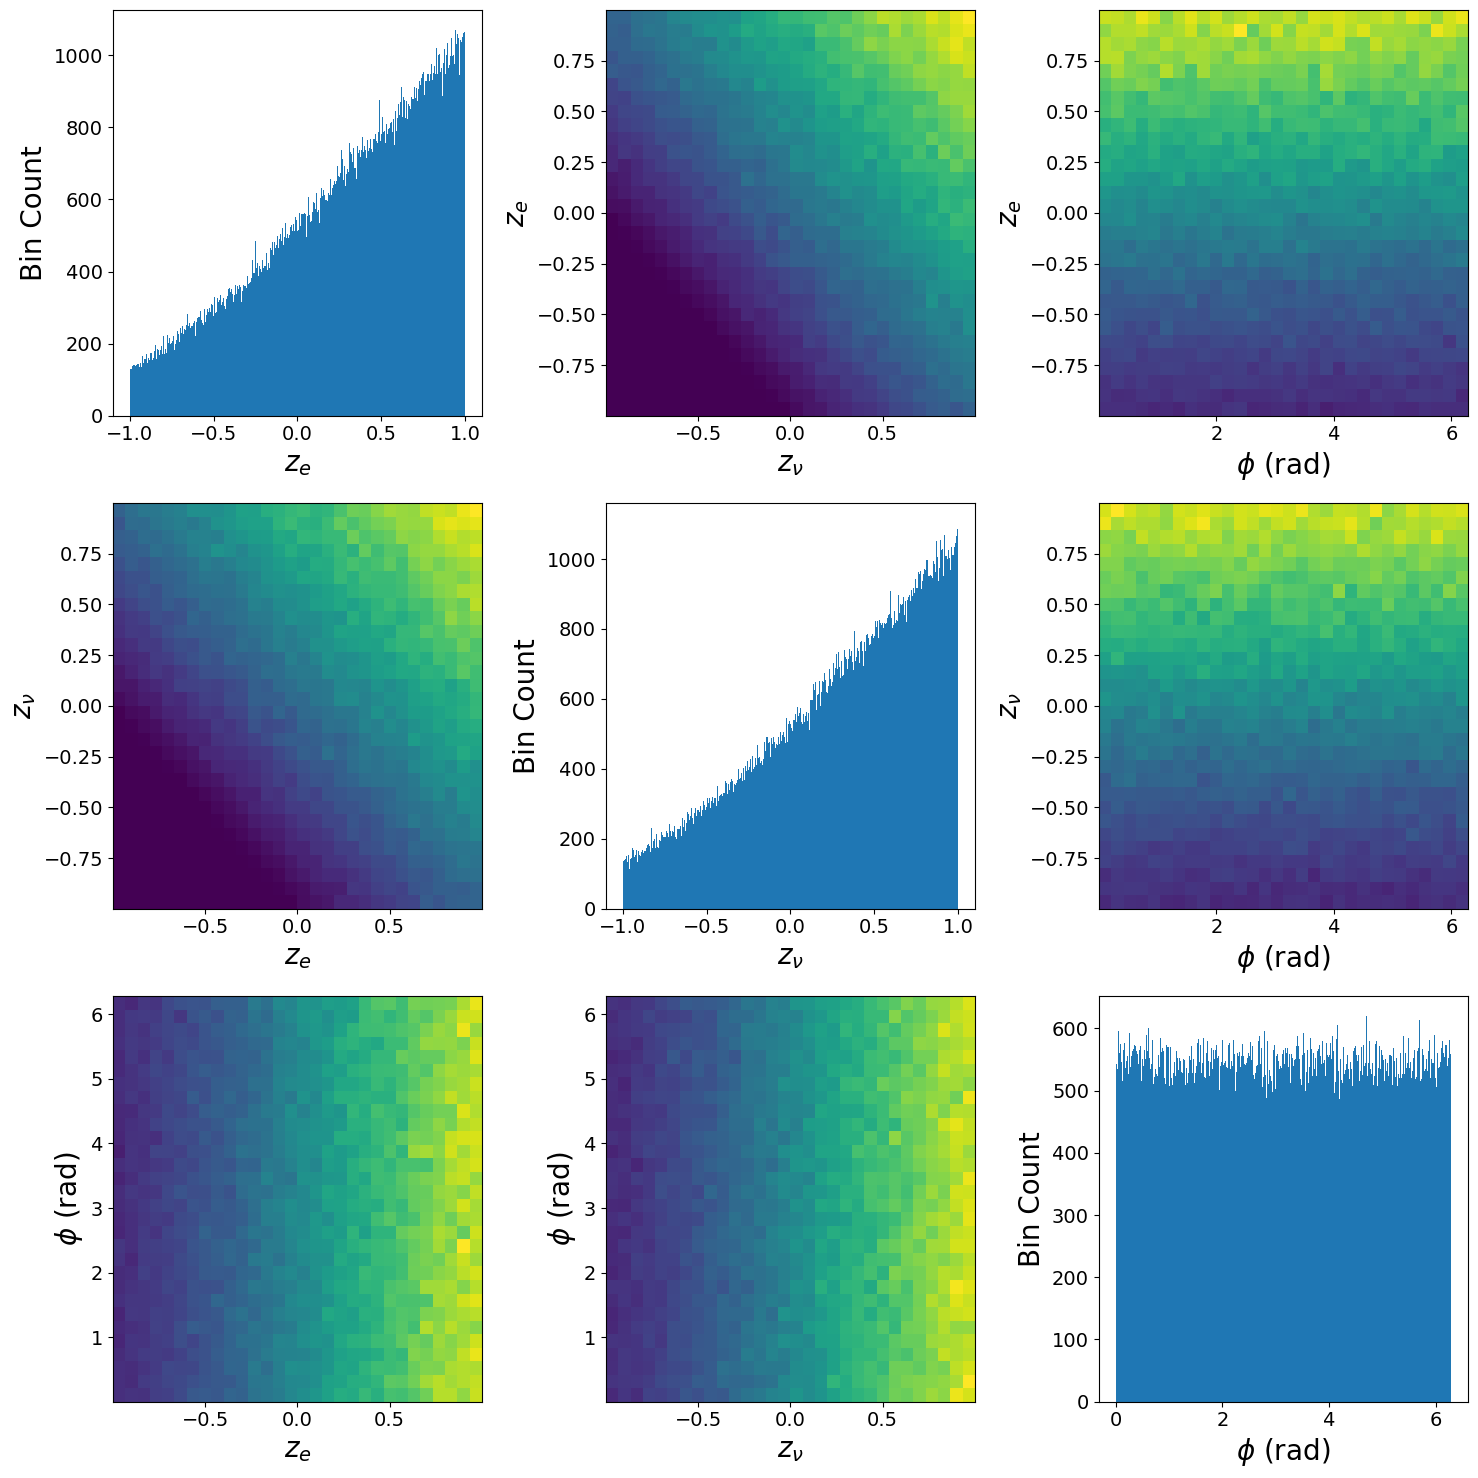

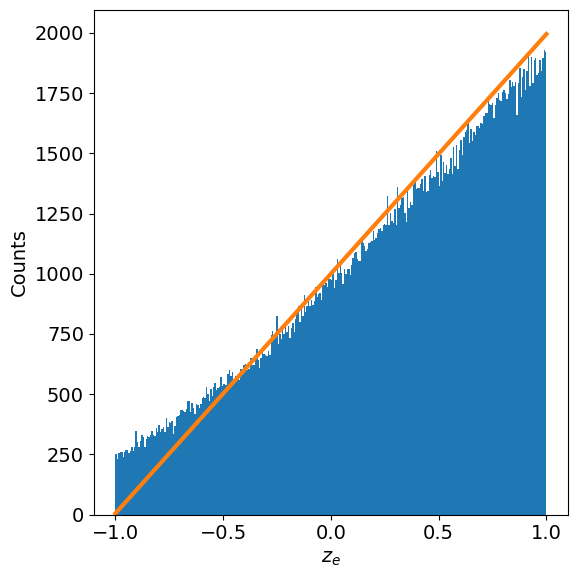

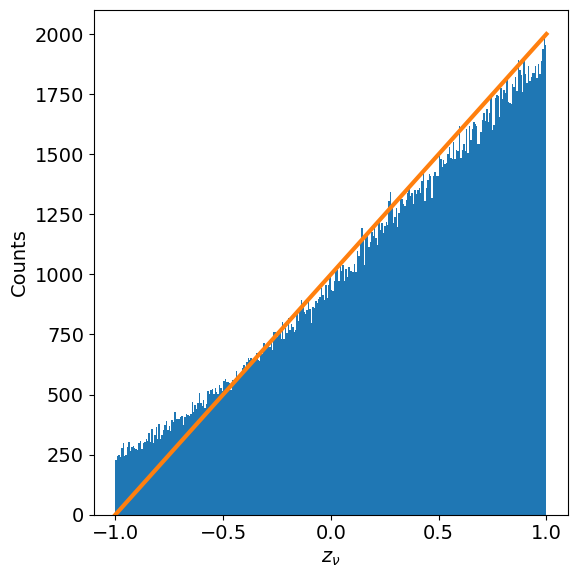

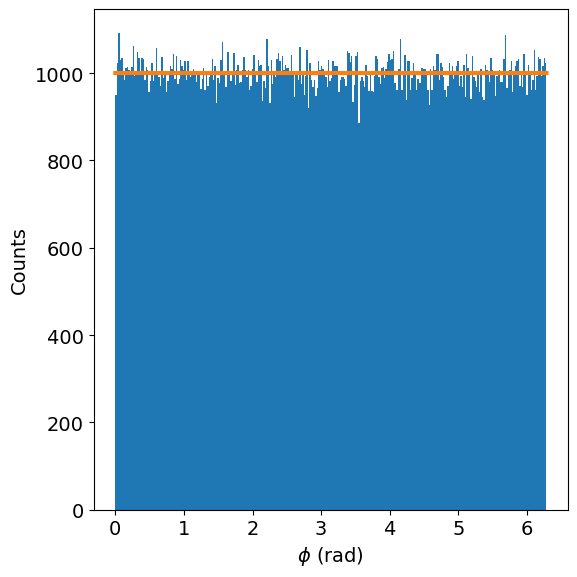

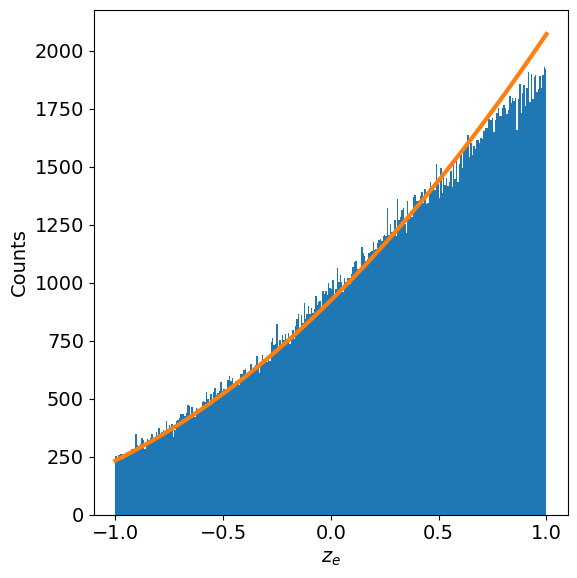

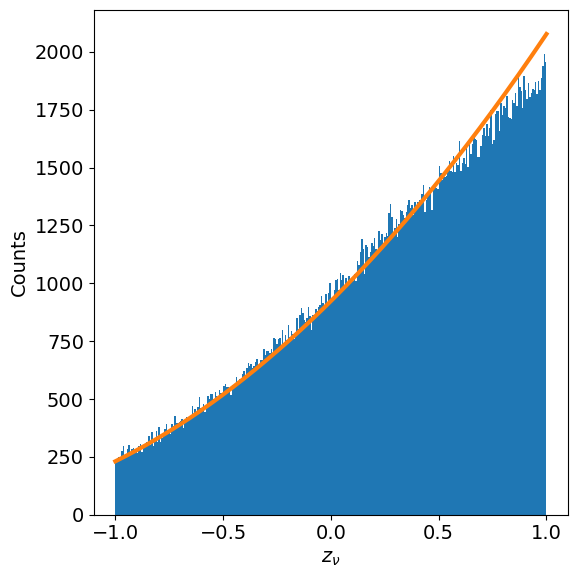

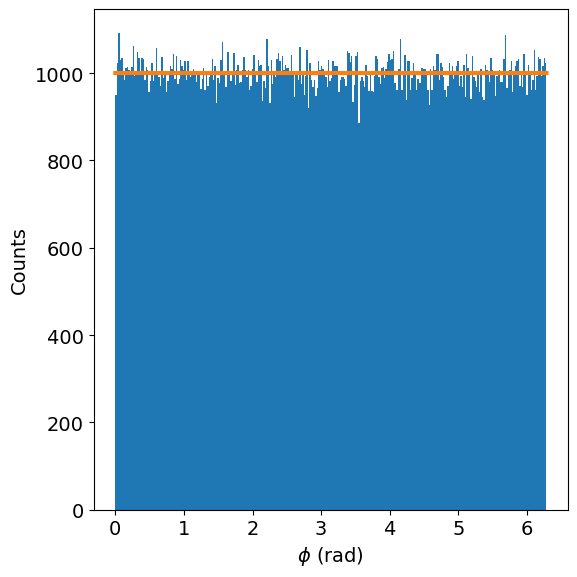

In [9]:
data = np.loadtxt("build/sample_posA_posB_hiE.txt")

beta = np.sqrt(1-511**2/5000**2)

def fx(x):
    return 1+beta*x

def fy(x):
    return 1+x

def fz(x):
    return np.ones_like(x)

plot_pairplot(data,filename="plots/sample_AB")
plot_histogram_components(data,n_bins=300,filename="plots/hist_AB",f_list=[fx,fy,fz])

def fx(x):
    return (1+beta*x+1/4*beta**2*x**2)/(1+beta**2/12)

def fy(x):
    return (1+x+1/4*x**2)/(13/12)

plot_histogram_components(data,n_bins=300,filename="plots/hist_AB_corr",f_list=[fx,fy,fz])

829.074978655558
996.59341381104


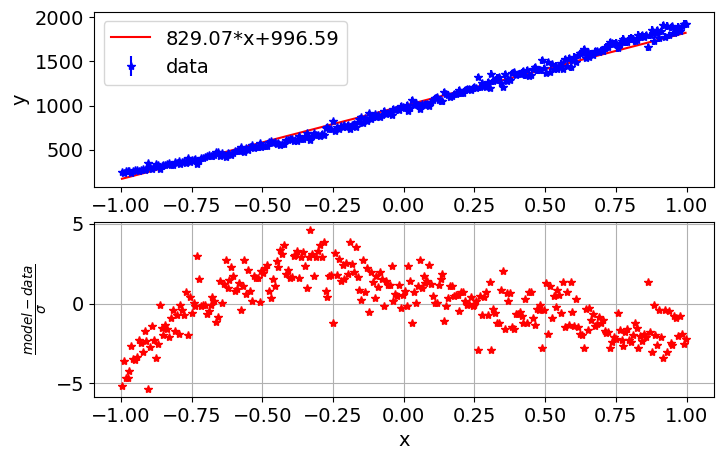

Percentage of points outside
1 sigma: 0.6233333333333333
2 sigma: 0.29
3 sigma: 0.09333333333333334

Bonus: Quadratic fit attempt

a=140.76296, b=866.77294, c=951.86209


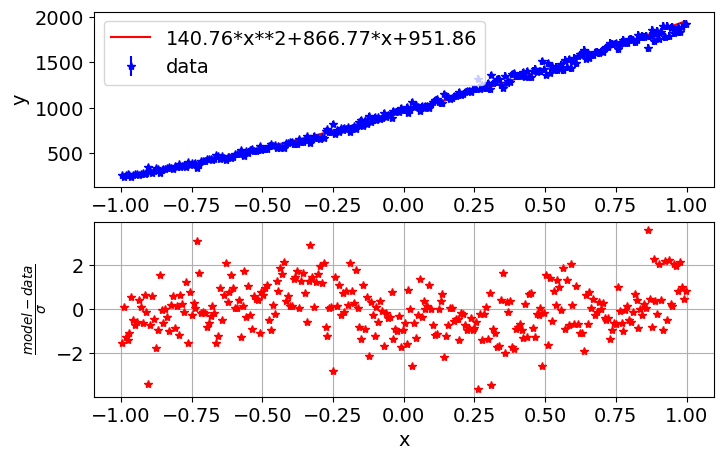

Percentage of points outside
1 sigma: 0.33
2 sigma: 0.07333333333333333
3 sigma: 0.016666666666666666
[0.14076296 0.86677294 0.95186209]
0.23095479121857782 0.9238191648743113 0.9238191648743113


In [10]:
def fit_linear_and_quad(x_i,y_i,sigma_i=None):
    coeffs = np.empty([3,2])
    
    try:
        if sigma_i == None:
            sigma_i = np.ones_like(x_i)
    except:
        pass
    sum_y2 = np.sum((y_i/sigma_i)**2)
    sum_y = np.sum(y_i/sigma_i**2)
    sum_x4 = np.sum((x_i**2/sigma_i)**2)
    sum_x3 = np.sum(x_i**3/sigma_i**2)
    sum_x2 = np.sum((x_i/sigma_i)**2)
    sum_x = np.sum(x_i/sigma_i**2)
    sum_xy = np.sum(x_i*y_i/sigma_i**2)
    sum_x2y = np.sum(x_i**2*y_i/sigma_i**2)
    sum_w = np.sum(1./sigma_i**2)

    a_estimated = -(sum_xy*sum_w-sum_x*sum_y)/(sum_x**2-sum_x2*sum_w)
    b_estimated = (sum_xy*sum_x-sum_x2*sum_y)/(sum_x**2-sum_x2*sum_w)

    print(a_estimated)
    print(b_estimated)
    
    coeffs[:,0] = [0,a_estimated,b_estimated]

    residual = (a_estimated*x_i+b_estimated-y_i)/sigma_i

    fig, ax = plt.subplots(2,1,figsize=(8, 5))
    ax[0].errorbar(x_i,y_i, sigma_i,color="b", fmt="*", label="data")
    ax[0].plot(x_i,a_estimated*x_i+b_estimated,"r",
               label=str(round(a_estimated,2))+"*x+"+str(round(b_estimated,2)))
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    ax[0].legend()
    ax[1].plot(x_i,residual,"r*")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("$\\frac{model-data}{\\sigma}$")
    ax[1].grid()

    plt.show()

    print("Percentage of points outside")
    print("1 sigma:",(np.sum(residual > 1)+np.sum(residual < -1))/residual.size)
    print("2 sigma:",(np.sum(residual > 2)+np.sum(residual < -2))/residual.size)
    print("3 sigma:",(np.sum(residual > 3)+np.sum(residual < -3))/residual.size)

    print("\nBonus: Quadratic fit attempt\n")

    #2nd order polinomial interpolation: use kramer to solve the system of equations
    matrix_den = np.array([[sum_x4,sum_x3,sum_x2],[sum_x3,sum_x2,sum_x],[sum_x2,sum_x,sum_w]])
    matrix_a = matrix_den.copy()
    matrix_a[0,:] = [sum_x2y,sum_xy,sum_y]
    matrix_b = matrix_den.copy()
    matrix_b[1,:] = [sum_x2y,sum_xy,sum_y]
    matrix_c = matrix_den.copy()
    matrix_c[2,:] = [sum_x2y,sum_xy,sum_y]

    a_estimated = np.linalg.det(matrix_a)/np.linalg.det(matrix_den)
    b_estimated = np.linalg.det(matrix_b)/np.linalg.det(matrix_den)
    c_estimated = np.linalg.det(matrix_c)/np.linalg.det(matrix_den)

    
    coeffs[:,1] = [a_estimated,b_estimated,c_estimated]
    
    print(f"a={a_estimated:.5f}, b={b_estimated:.5f}, c={c_estimated:.5f}")

    residual = (a_estimated*x_i**2+b_estimated*x_i+c_estimated-y_i)/sigma_i

    fig, ax = plt.subplots(2,1,figsize=(8, 5))
    ax[0].errorbar(x_i,y_i, sigma_i,color="b", fmt="*", label="data")
    ax[0].plot(x_i,a_estimated*x_i**2+b_estimated*x_i+c_estimated,"r",
               label=str(round(a_estimated,2))+"*x**2+"+str(round(b_estimated,2))+"*x+"+str(round(c_estimated,2)))
    ax[0].set_xlabel("x")
    ax[0].set_ylabel("y")
    ax[0].legend()
    ax[1].plot(x_i,residual,"r*")
    ax[1].set_xlabel("x")
    ax[1].set_ylabel("$\\frac{model-data}{\\sigma}$")
    ax[1].grid()
    plt.show()
        
    print("Percentage of points outside")
    print("1 sigma:",(np.sum(residual > 1)+np.sum(residual < -1))/residual.size)
    print("2 sigma:",(np.sum(residual > 2)+np.sum(residual < -2))/residual.size)
    print("3 sigma:",(np.sum(residual > 3)+np.sum(residual < -3))/residual.size)
    
    return coeffs
    
histo, bins = np.histogram(data[:,0],bins=300)
x_i = (bins[:-1] + bins[1:])/2
coeffs = fit_linear_and_quad(x_i,histo, sigma_i = np.sqrt(histo))[:,1]
fig.savefig("quadratic_fit.png")
print(coeffs/1000)
print(1/4/(1+beta**2/12),1/(1+beta**2/12),1/(1+beta**2/12))

(41, 41, 96)


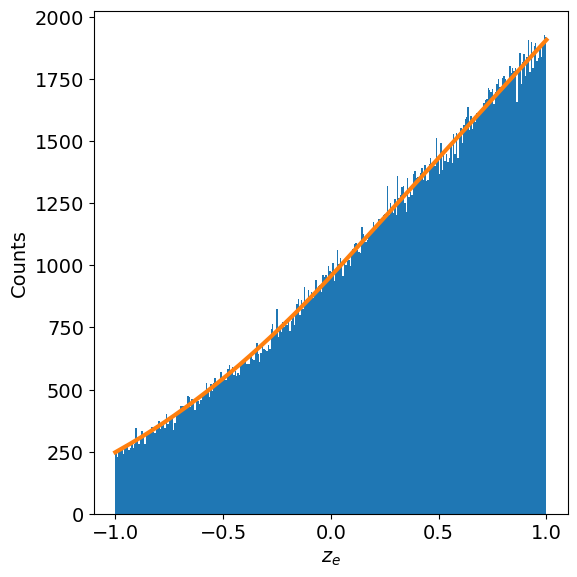

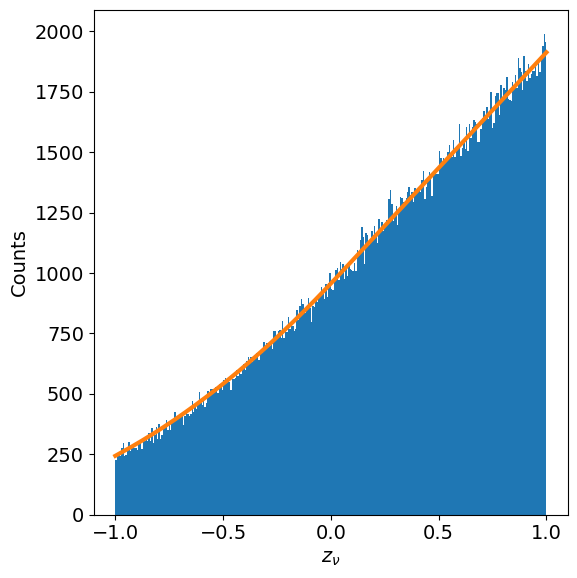

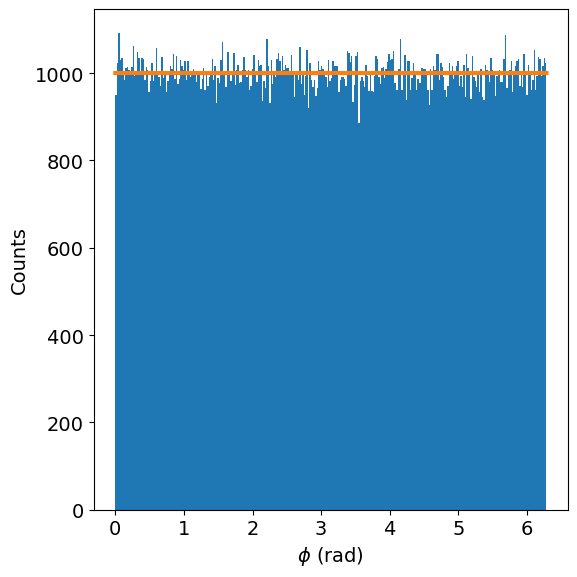

In [11]:
data2 = np.loadtxt("build/posA_posB_hiE.txt")
z_vals = int(np.sqrt(data2.shape[0]))
x_max = z_vals//2 
data2 = np.array(np.split(data2,z_vals,axis=0))
print(data2.shape)

data2[data2 < 0] = 0

x,y,z = np.indices(data2.shape)

z = z/(z.max()+1)*2*np.pi
x = (x-x_max)/x_max
y = (y-x_max)/x_max

x_list = x[:,0,0]
y_list = y[0,:,0]
z_list = z[0,0,:]


ze_dist = data2.sum(axis=2).sum(axis=1)/(data2.shape[1]*data2.shape[2])
ze_dist /= ze_dist.mean()
def fx(x):
    return np.interp(x,x_list,ze_dist)
znu_dist = data2.sum(axis=2).sum(axis=0)/(data2.shape[0]*data2.shape[2])
znu_dist /= znu_dist.mean()
def fy(x):
    return np.interp(x,y_list,znu_dist)
phi_dist = data2.sum(axis=0).sum(axis=0)/(data2.shape[0]*data2.shape[1])
phi_dist /= phi_dist.mean()
def fz(x):
    return np.interp(x,z_list,phi_dist,period=2*np.pi)


plot_histogram_components(data,n_bins=300,filename="plots/hist_AB_corr2",f_list=[fx,fy,fz])

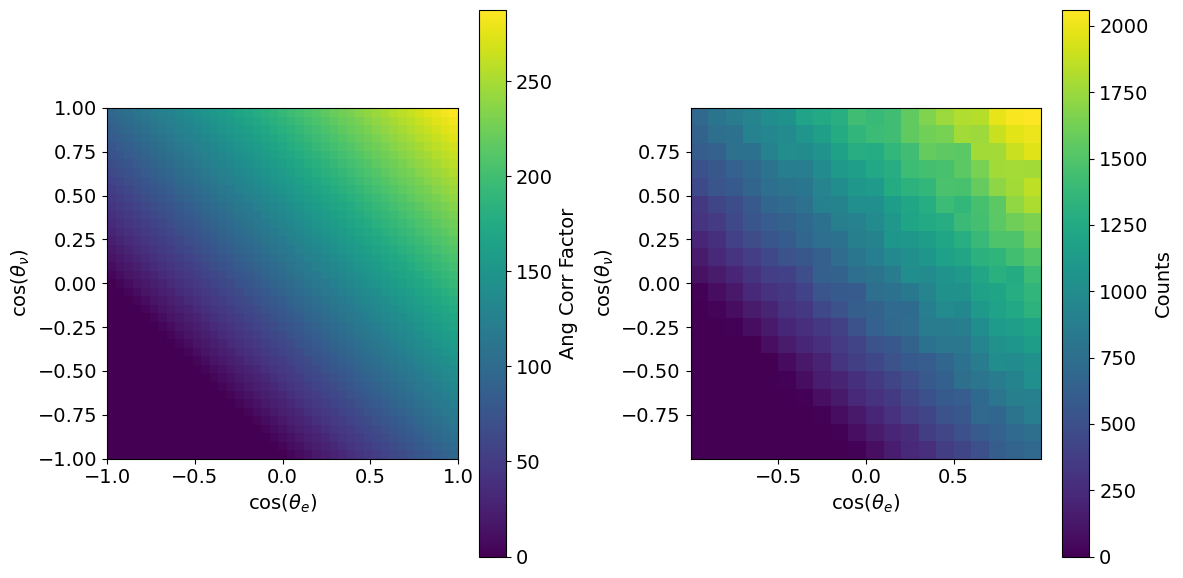

In [12]:
fig, axs = plt.subplots(1,2,figsize=(6*2,6))
im2d = axs[0].imshow(data2.sum(axis=2).T,extent=(-1,1,-1,1),origin="lower")
axs[0].set_xlabel("$\\cos(\\theta_e)$")
axs[0].set_ylabel("$\\cos(\\theta_\\nu)$")
fig.colorbar(im2d,label="Ang Corr Factor",shrink=1,fraction=0.1)
ax = axs[1]
histo2d = ax.hist2d(data[:,0],data[:,1],bins=20)
ax.set_xlabel("$\\cos(\\theta_e)$")
ax.set_ylabel("$\\cos(\\theta_\\nu)$")
ax.set_aspect('equal')
fig.colorbar(histo2d[3],label="Counts",shrink=1,fraction=0.1)
fig.tight_layout()
fig.savefig(f"plots/sample_AB_hists.png")
plt.show()

(41, 41, 96)
29983761.72909655
29940257.835860223
30001581.35766376


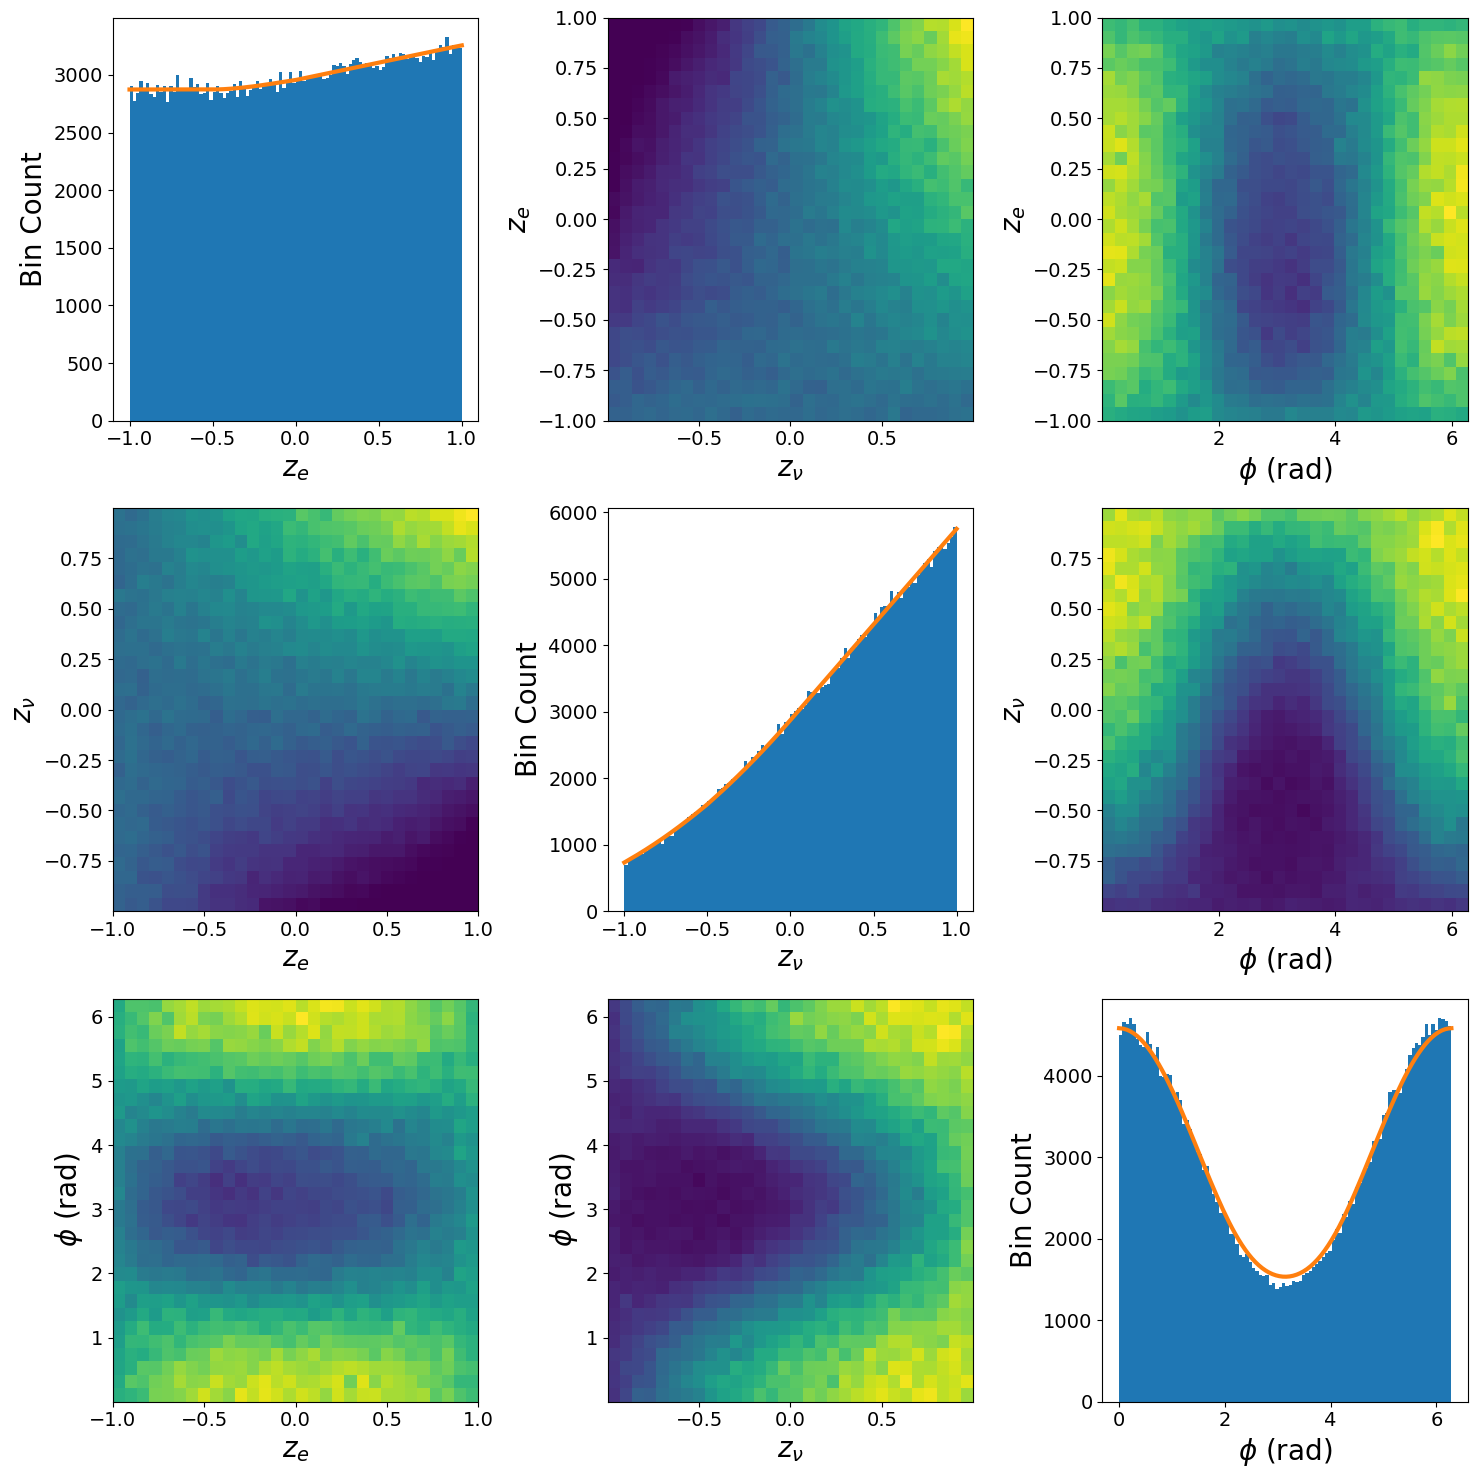

In [13]:
data = np.loadtxt("build/sample_posa_posB_hiE.txt")
data2 = np.loadtxt("build/posa_posB_hiE.txt")
z_vals = int(np.sqrt(data2.shape[0]))
x_max = z_vals//2 
data2 = np.array(np.split(data2,z_vals,axis=0))
print(data2.shape)

data2[data2 < 0] = 0

x,y,z = np.indices(data2.shape)

z = z/(z.max()+1)*2*np.pi
x = (x-x_max)/x_max
y = (y-x_max)/x_max

x_list = x[:,0,0]
y_list = y[0,:,0]
z_list = z[0,0,:]


ze_dist = data2.sum(axis=2).sum(axis=1)/(data2.shape[1]*data2.shape[2])
ze_dist /= ze_dist.mean()

def fx(x):
    return np.interp(x,x_list,ze_dist)

znu_dist = data2.sum(axis=2).sum(axis=0)/(data2.shape[0]*data2.shape[2])
znu_dist /= znu_dist.mean()

def fy(x):
    return np.interp(x,y_list,znu_dist)

phi_dist = data2.sum(axis=0).sum(axis=0)/(data2.shape[0]*data2.shape[1])
phi_dist /= phi_dist.mean()

def fz(x):
    return np.interp(x,z_list,phi_dist,period=2*np.pi)


plot_pairplot(data,n_bins=100,filename="plots/sample_aB_hiE_",f_list=[fx,fy,fz])

(162081, 96)
(81, 2001, 96)
81.0
-1.0 1.0 0.0 6.276902121872406
2000.9999999999998
2001.0000000000002
30006287.63162576
30000202.81701046
29999949.288355596


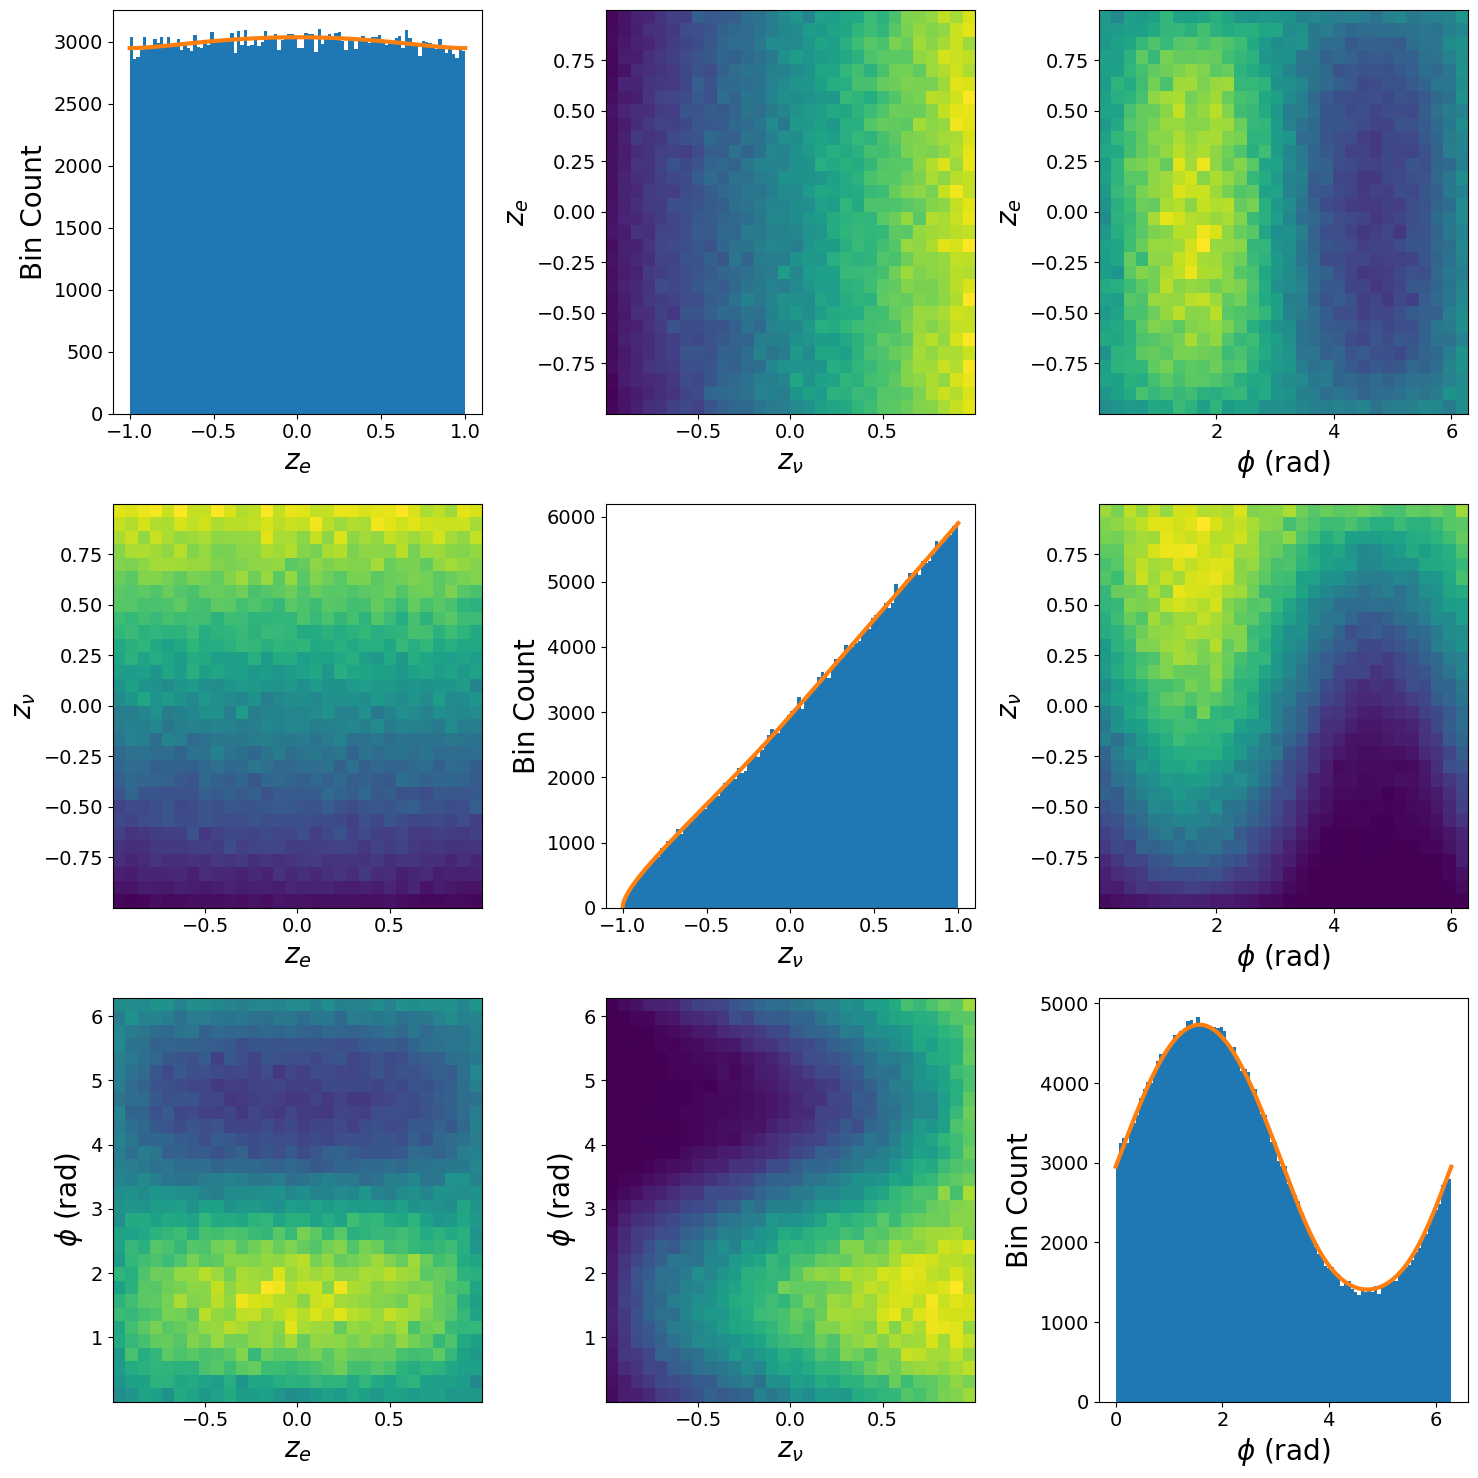

30006287.63162576
30000204.304791838
29999949.288355596


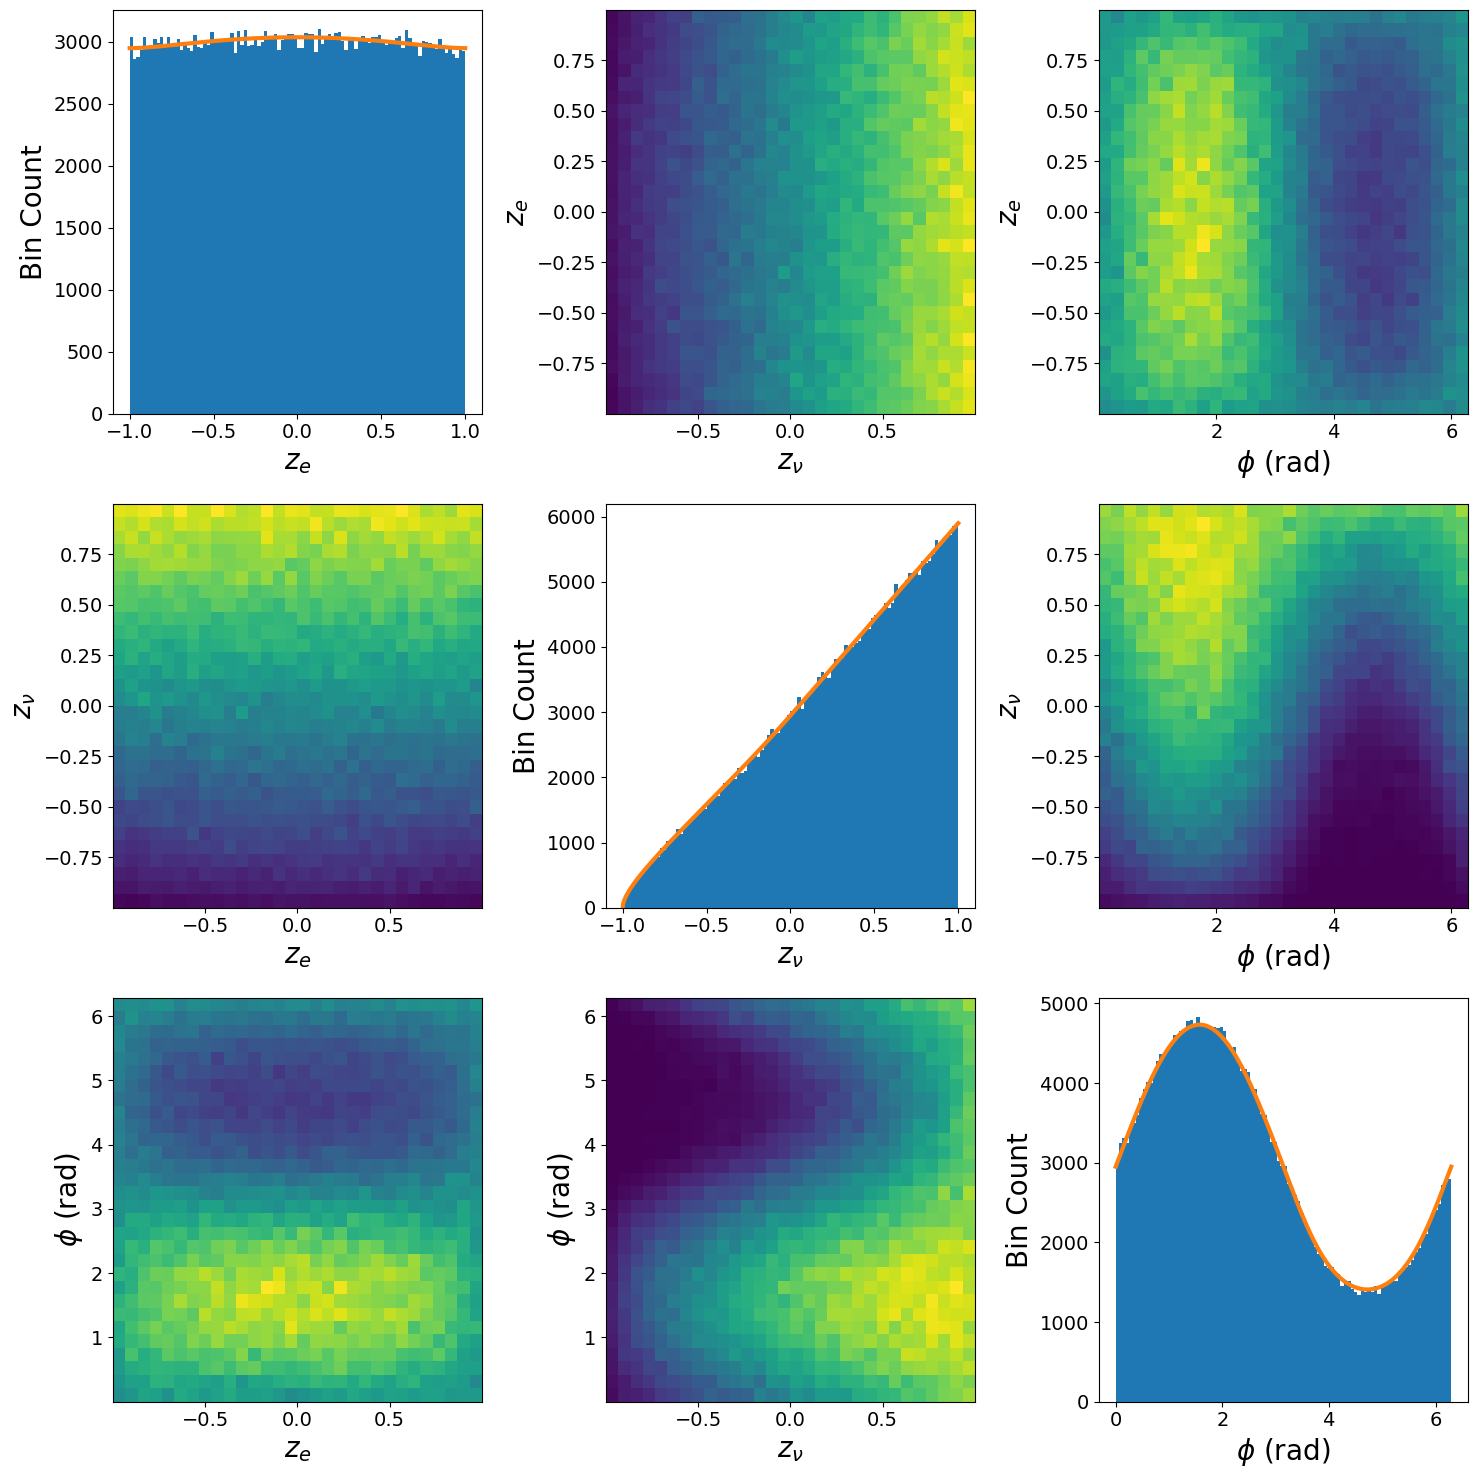

In [37]:
data = np.loadtxt("build/sample_posD_posB_hiE.txt")
data2 = np.loadtxt("build/posD_posB_hiE.txt")

print(data2.shape)

x_max = 40

data2 = np.array(np.split(data2,81,axis=0))
print(data2.shape)

y_max = data2.shape[1]//2

x,y,z = np.indices(data2.shape)

z = z/(z.max()+1)*2*np.pi
x = (x-x_max)/x_max
y = (y-y_max)/y_max

x_list = x[:,0,0]
y_list = y[0,:,0]
z_list = z[0,0,:]

data2[data2 < 0] = 0

ze_dist = data2.sum(axis=2).sum(axis=1)/(data2.shape[1]*data2.shape[2])
ze_dist /= ze_dist.mean()
print(ze_dist.sum())

def fx(x):
    return np.interp(x,x_list,ze_dist)


D = np.sqrt(1-(511/5000)**2)

znu_dist2 = np.empty_like(np.linspace(-1,1,2001)) 

ze, phi = np.indices((201,1000)) 
phi = phi*2.*np.pi/1000.
ze = ze/100.0-1.0
print(ze.min(),ze.max(),phi.min(),phi.max())

for i, znu in enumerate(np.linspace(-1,1,2001)):
    F = 1+znu+D*np.sqrt((1-ze**2)*(1-znu**2))*np.sin(phi)
    F[F < 0] = 0
    znu_dist2[i] = np.sum(F)
znu_dist2 /= znu_dist2.mean()
print(znu_dist2.sum())

znu_dist = data2.sum(axis=0).sum(axis=1)/(data2.shape[0]*data2.shape[2])
znu_dist /= znu_dist.mean()
print(znu_dist.sum())

def fy(x):
    return np.interp(x,y_list,znu_dist)

def fy2(x):
    return np.interp(x,np.linspace(-1,1,2001),znu_dist2)

phi_dist = data2.sum(axis=0).sum(axis=0)/(data2.shape[0]*data2.shape[1])
phi_dist /= phi_dist.mean()

def fz(x):
    return np.interp(x,z_list,phi_dist,period=2*np.pi)


plot_pairplot(data,n_bins=100,filename="plots/sample_DB_hiE_",f_list=[fx,fy,fz])
plot_pairplot(data,n_bins=100,f_list=[fx,fy2,fz])

(162081, 96)
(2001, 81, 96)
2001.0
30000205.99916105
30006386.283068508
29999948.492702857


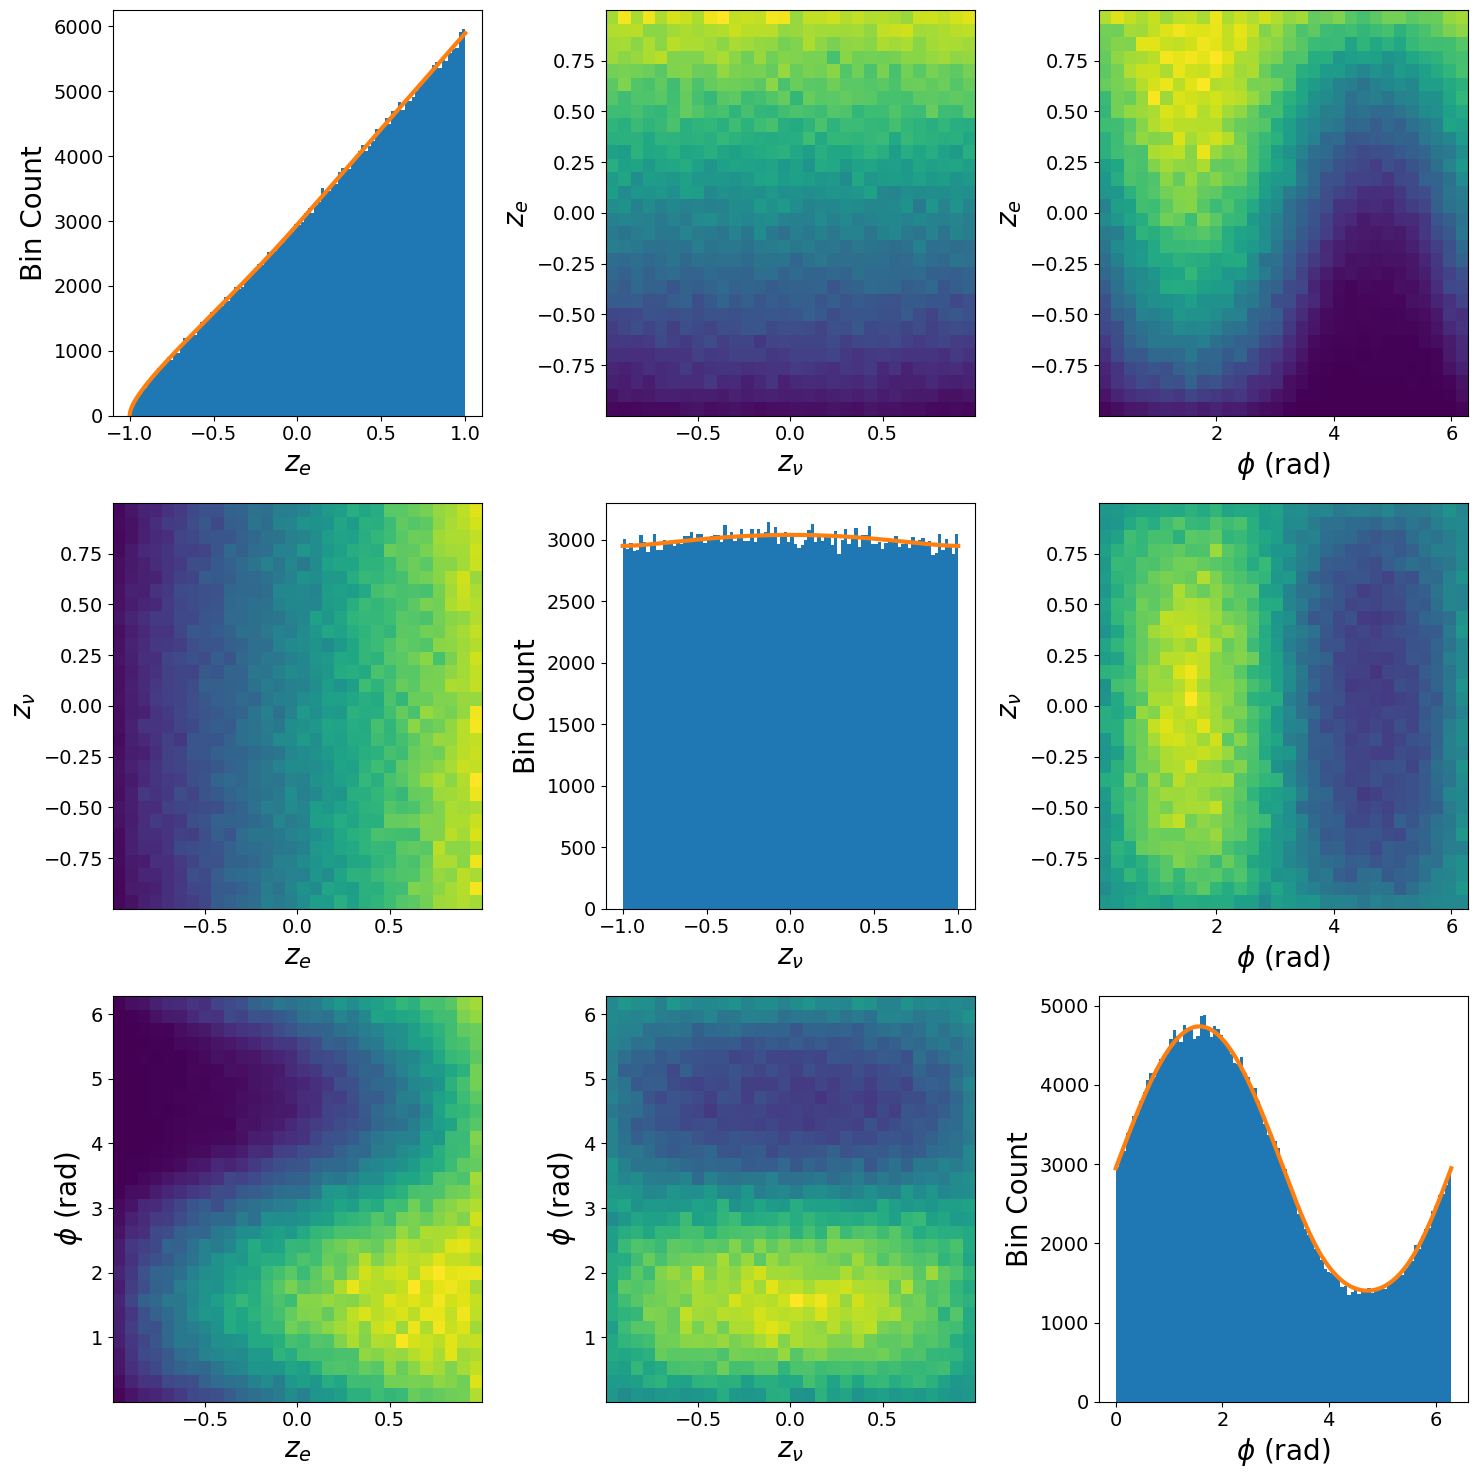

In [38]:
data = np.loadtxt("build/sample_posD_eqposA.txt")
data2 = np.loadtxt("build/posD_eqposA.txt")

print(data2.shape)

data2 = np.array(np.split(data2,2001,axis=0))
print(data2.shape)

x,y,z = np.indices(data2.shape)

y_max = 40
x_max = data2.shape[0]//2

z = z/(z.max()+1)*2*np.pi
x = (x-x_max)/x_max
y = (y-y_max)/y_max

x_list = x[:,0,0]
y_list = y[0,:,0]
z_list = z[0,0,:]

data2[data2 < 0] = 0

ze_dist = data2.sum(axis=2).sum(axis=1)/(data2.shape[1]*data2.shape[2])
ze_dist /= ze_dist.mean()
print(ze_dist.sum())

def fx(x):
    return np.interp(x,x_list,ze_dist)

znu_dist = data2.sum(axis=2).sum(axis=0)/(data2.shape[0]*data2.shape[2])
znu_dist /= znu_dist.mean()

def fy(x):
    return np.interp(x,y_list,znu_dist)

phi_dist = data2.sum(axis=0).sum(axis=0)/(data2.shape[0]*data2.shape[1])
phi_dist /= phi_dist.mean()

def fz(x):
    return np.interp(x,z_list,phi_dist,period=2*np.pi)


plot_pairplot(data,n_bins=100,filename="plots/sample_DA_eqpos_",f_list=[fx,fy,fz])

29940120.74124559
29983730.209776577
30001588.460283384


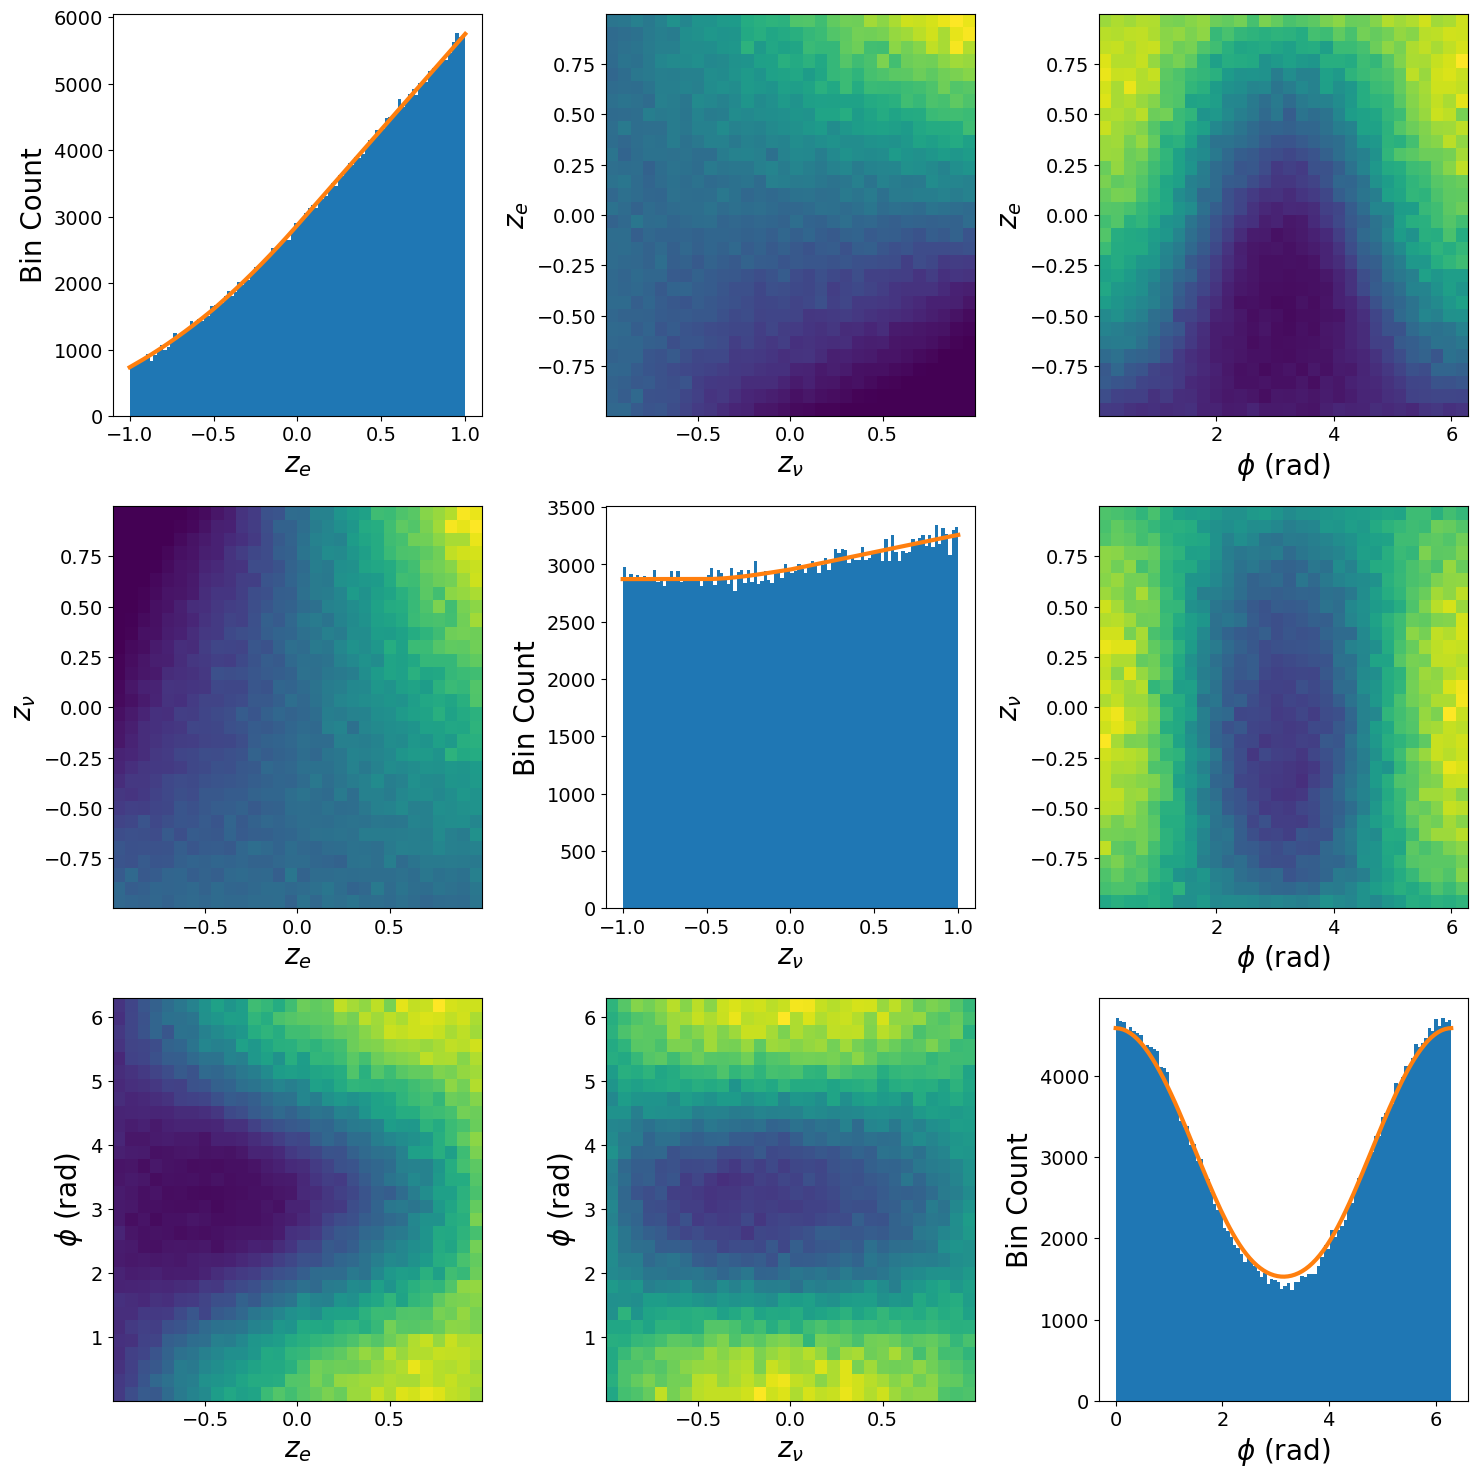

In [16]:
data = np.loadtxt("build/sample_posa_eqposA.txt")
data2 = np.loadtxt("build/posa_eqposA.txt")

z_max = int(np.sqrt(data2.shape[0]))
data2 = np.array(np.split(data2,z_max,axis=0))
x, y, z = np.indices(data2.shape)
x_max = data2.shape[0]//2
y_max = x_max

z = z/(z.max()+1)*2*np.pi
x = (x-x_max)/x_max
y = (y-x_max)/x_max

x_list = x[:,0,0]
y_list = y[0,:,0]
z_list = z[0,0,:]

data2[data2 < 0] = 0


ze_dist = data2.sum(axis=2).sum(axis=1)/(data2.shape[1]*data2.shape[2])
ze_dist /= ze_dist.mean()
def fx(x):
    return np.interp(x,x_list,ze_dist)
znu_dist = data2.sum(axis=2).sum(axis=0)/(data2.shape[0]*data2.shape[2])
znu_dist /= znu_dist.mean()
def fy(x):
    return np.interp(x,y_list,znu_dist)
phi_dist = data2.sum(axis=0).sum(axis=0)/(data2.shape[0]*data2.shape[1])
phi_dist /= phi_dist.mean()
def fz(x):
    return np.interp(x,z_list,phi_dist,period=2*np.pi)


plot_pairplot(data,n_bins=100,filename="plots/sample_aA_eqpos_",f_list=[fx,fy,fz])

30002530.446824286
30002530.446824286
30001747.628260493


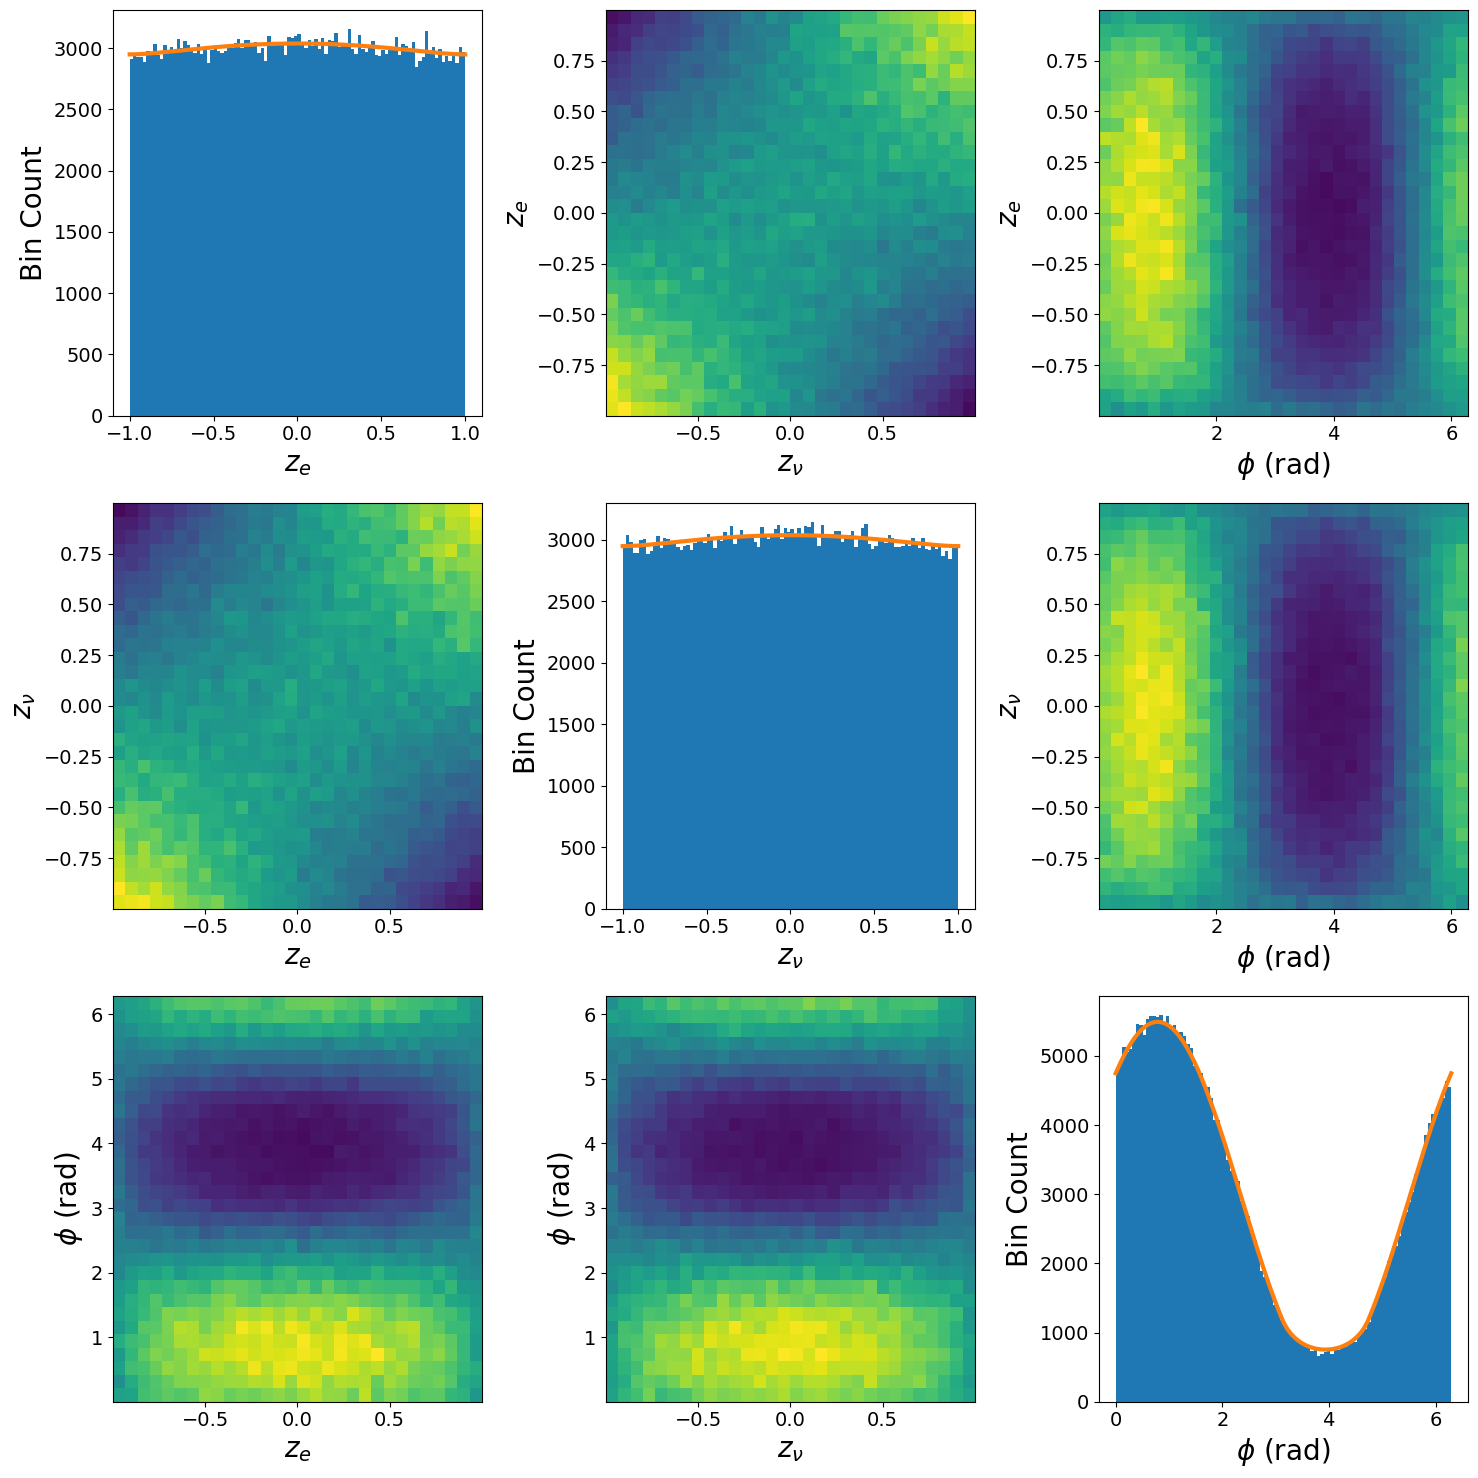

In [17]:
data = np.loadtxt("build/sample_posa_eqposD.txt")
data2 = np.loadtxt("build/posa_eqposD.txt")

z_max = int(np.sqrt(data2.shape[0]))
data2 = np.array(np.split(data2,z_max,axis=0))
x, y, z = np.indices(data2.shape)
x_max = data2.shape[0]//2
y_max = x_max

z = z/(z.max()+1)*2*np.pi
x = (x-x_max)/x_max
y = (y-x_max)/x_max

x_list = x[:,0,0]
y_list = y[0,:,0]
z_list = z[0,0,:]

data2[data2 < 0] = 0


ze_dist = data2.sum(axis=2).sum(axis=1)/(data2.shape[1]*data2.shape[2])
ze_dist /= ze_dist.mean()
def fx(x):
    return np.interp(x,x_list,ze_dist)
znu_dist = data2.sum(axis=2).sum(axis=0)/(data2.shape[0]*data2.shape[2])
znu_dist /= znu_dist.mean()
def fy(x):
    return np.interp(x,y_list,znu_dist)
phi_dist = data2.sum(axis=0).sum(axis=0)/(data2.shape[0]*data2.shape[1])
phi_dist /= phi_dist.mean()
def fz(x):
    return np.interp(x,z_list,phi_dist,period=2*np.pi)


plot_pairplot(data,n_bins=100,filename="plots/sample_aD_eqpos_",f_list=[fx,fy,fz])

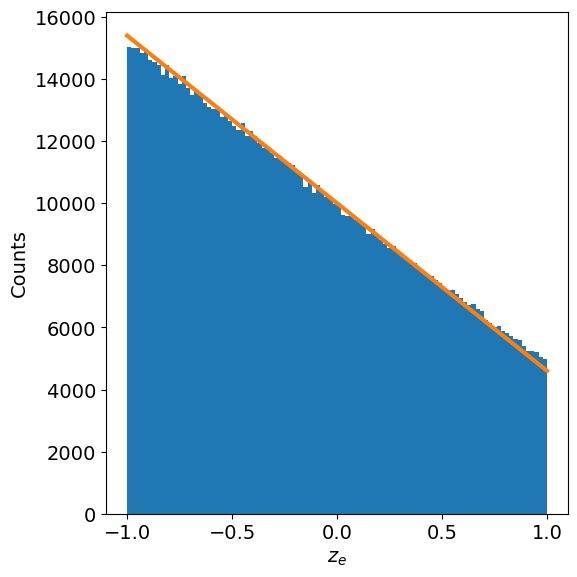

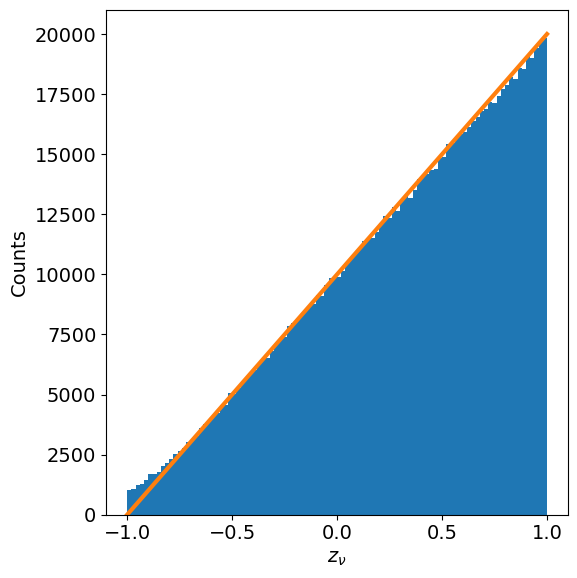

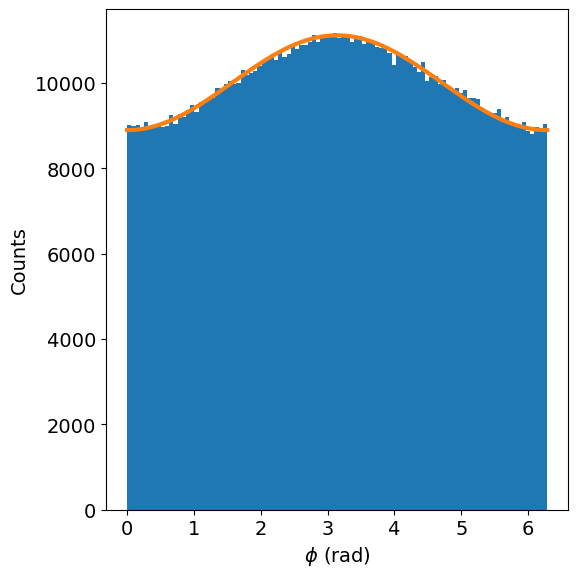

In [18]:
data = np.loadtxt("build/sample_aAB.txt")
beta = np.sqrt(1-511**2/(607)**2)

def fx(x):
    return 1-beta*x

def fy(x):
    return 1+x

def fz(x):
    return 1-1/3*beta*np.cos(x)*(np.pi/4)**2
    
plot_histogram_components(data,100,f_list=[fx,fy,fz],filename="plots/hist_aAB")

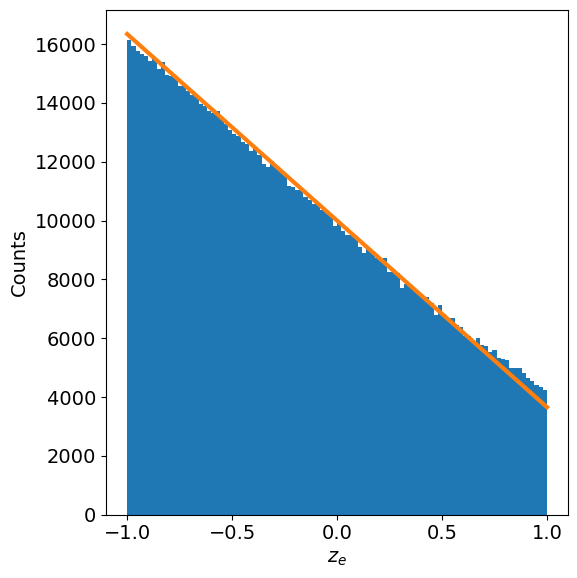

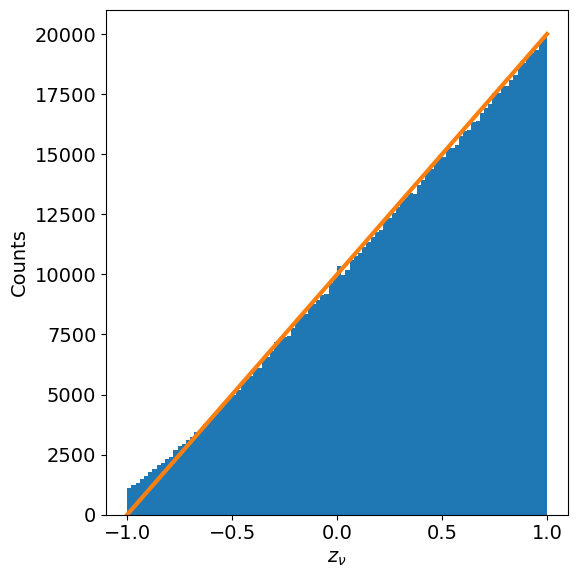

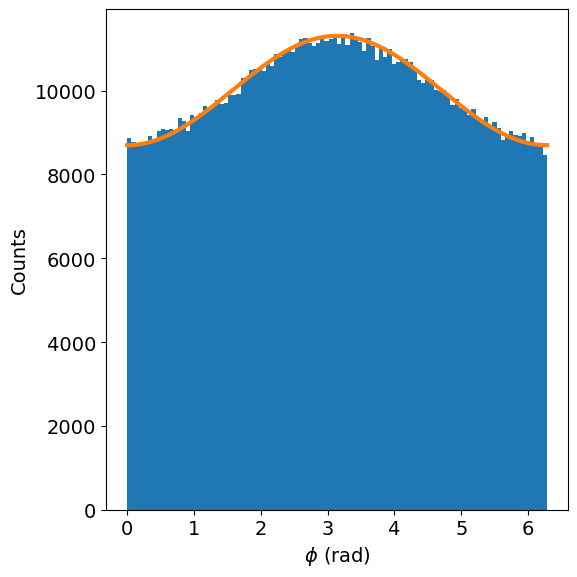

In [19]:
data = np.loadtxt("build/sample_aAB_2.txt")
beta = np.sqrt(1-511**2/(661)**2)

def fx(x):
    return 1-beta*x

def fy(x):
    return 1+x

def fz(x):
    return 1-1/3*beta*np.cos(x)*(np.pi/4)**2
    
plot_histogram_components(data,100,f_list=[fx,fy,fz],filename="plots/hist_aAB_2")